# Projeto Final Núclio - Ds Market

## Tarefas a serem executadas

In [ ]:
# TASKS:
#
#       Analysys:
#           - Premisses: Your work during these first months will focus in our stores from 3 big cities (NY, Boston & Philadelphia)
#
#           - Task #1: My intuition says that we probably have some products that are not
#                      so popular any more, and it’s likely that most popular products vary across cities, or even across
#                      stores (which might vary in prices as well). Our marketing actions will be exploiting those
#                      differences. We need to understand every single detail of the business!
#
#           - Task #2: Do you think you could also work in a BI service that would allow us to follow the
#                      main results of your analysis on a regular basis? That would be super useful for the executive board.
#                      Just use the dashboarding solution that you feel more comfortable with.
#
#       Clustering:
#           - Task #1: we could identify groups of
#                      products that behave in a similar way. Michelle was saying that with your magic it’s easy to
#                      identify groups of similar products, and such groups will be super useful to evaluate the
#                      performance of our different campaigns. How many groups do you think we should consider? 5? 10? 20?
#
#           - Task #2: Also, do you think we could find a “solid” approach to identify how similar are stores to one
#                      another? Would store clustering also make sense here? Could you also do that?
#
#       Sales Forecasting:
#           - Task #1: We usually start predicting sales at a store-product level, and to obtain aggregated sales per
#                      department/store/city we add up the independent predictions. Would that be still a valid
#                      approach? Let’s start with 28 days predictions (4 weeks).
#
#                       - Premisse: We have a few additional weeks of data available with which we will be able to test the predictive error of the model.
#
#       Store replenishment use case (with MLOps):
#           - Task #1: JUST A DRAFT! How are those sales predictions coming up? The Operations Department is already considering the
#                      application of your advanced predictive models for one of their most critical use cases: stores
#                      replenishment. Albeit if needed, the stock for some products can be replenished on a daily basis,
#                      the supplies to provision stores are mostly distributed on a weekly basis (beginning of each week).
#                      You’re probably already visualizing the importance of sales predictions for that. Minimizing the
#                      remanent stock is every retailer’s desire, but that desire is even stronger for supermarket items.
#                      Could you please draft a proposal detailing your solution to apply the sales predictors to the stores
#                      supply use case? We would also need to specify any extensions that the models might require, as
#                      well as the productization details for the use case. Martin requested the deployment of an API for
#                      its execution. Is it something you would be comfortable with? Do not worry about the
#                      implementation for now, let’s just focus on that draft.
#
#           - Task #2: I would like you to design a pilot test to confidently demonstrate
#                      the improvements directly associated to the new approach (i.e. dollars!). The creation of a data
#                      driven culture should be one of our priorities at this stage, and it is important that everyone starts
#                      believing in the power of this type of algorithms. I’m thinking of a case-control study (maybe by
#                      products or stores? maybe both?). You are the expert! What would you do and how would you
#                      evaluate it? Can you please send me a proposal?

## Instalando bibliotecas

In [ ]:
!pip install ydata_profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!pip install powerbiclient

In [ ]:
# Instalando o kmodes para a clusterização de dados categóricos e numéricos
!pip install kmodes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#%pip install -U plotly-orca

## Importando Bibliotecas

In [4]:
#importando bibliotecas básicas
import pandas as pd
import datetime
from ydata_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder,  OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import model_selection, metrics, tree
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_score
from scipy.stats import pearsonr
from scipy import stats
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import plotly.offline as offline
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.palettes import Category10
from bokeh.transform import cumsum
from bokeh.io import output_notebook

%matplotlib inline
#from powerbiclient import Report, models
#from powerbiclient import QuickVisualize, get_dataset_config
#from powerbiclient.authentication import DeviceCodeLoginAuthentication

from kmodes.kprototypes import KPrototypes

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'kmodes'

## Importando Datasets

In [8]:
#importando datasets diretamente do google drive - desse modo não é necessário regarregar os arquivos a cada vez que é aberto
calendar = pd.read_csv("daily_calendar_with_events.csv")
prices = pd.read_csv("item_prices.csv")
sales = pd.read_csv("item_sales.csv")

## Tratamento dos Dados

### Dataset Calendar

In [9]:
print(calendar.shape)

(1913, 5)


In [12]:
#informações sobre as colunas e tipos de dados
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         1913 non-null   object
 1   weekday      1913 non-null   object
 2   weekday_int  1913 non-null   int64 
 3   d            1913 non-null   object
 4   event        26 non-null     object
dtypes: int64(1), object(4)
memory usage: 74.9+ KB


In [14]:
#Verificar as primeiras linhas do DataFrame
calendar.head()

date    weekday  weekday_int    d event
0  2011-01-29   Saturday            1  d_1   NaN
1  2011-01-30     Sunday            2  d_2   NaN
2  2011-01-31     Monday            3  d_3   NaN
3  2011-02-01    Tuesday            4  d_4   NaN
4  2011-02-02  Wednesday            5  d_5   NaN

In [16]:
#Verificar as primeiras linhas do DataFrame
calendar.head()

date    weekday  weekday_int    d event
0  2011-01-29   Saturday            1  d_1   NaN
1  2011-01-30     Sunday            2  d_2   NaN
2  2011-01-31     Monday            3  d_3   NaN
3  2011-02-01    Tuesday            4  d_4   NaN
4  2011-02-02  Wednesday            5  d_5   NaN

In [18]:
#verificando estatísticas resumidas dos dados
calendar.describe(include='all').T

count unique         top freq      mean       std  min  25%  \
date           1913   1913  2011-01-29    1       NaN       NaN  NaN  NaN   
weekday        1913      7    Saturday  274       NaN       NaN  NaN  NaN   
weekday_int  1913.0    NaN         NaN  NaN  3.997386  2.001175  1.0  2.0   
d              1913   1913         d_1    1       NaN       NaN  NaN  NaN   
event            26      5   SuperBowl    6       NaN       NaN  NaN  NaN   

             50%  75%  max  
date         NaN  NaN  NaN  
weekday      NaN  NaN  NaN  
weekday_int  4.0  6.0  7.0  
d            NaN  NaN  NaN  
event        NaN  NaN  NaN

In [20]:
#quantidade de valores únicos em cada coluna
calendar.nunique()

date           1913
weekday           7
weekday_int       7
d              1913
event             5
dtype: int64

In [22]:
#verificando a quantidade de registros com valores nullos
calendar.isnull().sum()

date              0
weekday           0
weekday_int       0
d                 0
event          1887
dtype: int64

In [24]:
#verificando se há registros duplicados
calendar.duplicated().sum()

0

In [26]:
# Selecionando apenas as linhas com valores não nulos na coluna "event" para avaliar realizar drop nela

not_null_rows = calendar['event'].notnull()
# apresentando os dias de evento com a data e a semana/ano
filtered_df = calendar.loc[not_null_rows, ['date', 'event']]
print(filtered_df)

            date           event
8     2011-02-06       SuperBowl
184   2011-08-01  Ramadan starts
299   2011-11-24    Thanksgiving
337   2012-01-01         NewYear
372   2012-02-05       SuperBowl
435   2012-04-08          Easter
538   2012-07-20  Ramadan starts
663   2012-11-22    Thanksgiving
703   2013-01-01         NewYear
736   2013-02-03       SuperBowl
792   2013-03-31          Easter
892   2013-07-09  Ramadan starts
1034  2013-11-28    Thanksgiving
1068  2014-01-01         NewYear
1100  2014-02-02       SuperBowl
1177  2014-04-20          Easter
1247  2014-06-29  Ramadan starts
1398  2014-11-27    Thanksgiving
1433  2015-01-01         NewYear
1464  2015-02-01       SuperBowl
1527  2015-04-05          Easter
1601  2015-06-18  Ramadan starts
1762  2015-11-26    Thanksgiving
1798  2016-01-01         NewYear
1835  2016-02-07       SuperBowl
1884  2016-03-27          Easter


In [149]:
#eliminando coluna weekday pois já temos ela encoded na coluna weekday_int
#eliminando coluna event devido pouquissimos registros serem not null
calendar.drop('weekday', axis=1, inplace=True)
calendar.drop('event', axis=1, inplace=True)

In [150]:
#Corrigindo Data types
calendar['date'] = pd.to_datetime(calendar['date'])

In [151]:
#criando coluna yearweek para ser compatível com os dados do dataframe prices
calendar['yearweek'] = calendar['date'].apply(lambda x: datetime.datetime.strftime(x, "%Y%U"))

In [152]:
calendar['yearweek'] = calendar['yearweek'].astype(int)

In [153]:
calendar.dtypes

date           datetime64[ns]
weekday_int             int64
d                      object
yearweek                int32
dtype: object

In [154]:
#Dados depois das correções
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1913 non-null   datetime64[ns]
 1   weekday_int  1913 non-null   int64         
 2   d            1913 non-null   object        
 3   yearweek     1913 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 52.4+ KB


In [155]:
#verificando primeiras linhas novamente
calendar.head(14)

date  weekday_int     d  yearweek
0  2011-01-29            1   d_1    201104
1  2011-01-30            2   d_2    201105
2  2011-01-31            3   d_3    201105
3  2011-02-01            4   d_4    201105
4  2011-02-02            5   d_5    201105
5  2011-02-03            6   d_6    201105
6  2011-02-04            7   d_7    201105
7  2011-02-05            1   d_8    201105
8  2011-02-06            2   d_9    201106
9  2011-02-07            3  d_10    201106
10 2011-02-08            4  d_11    201106
11 2011-02-09            5  d_12    201106
12 2011-02-10            6  d_13    201106
13 2011-02-11            7  d_14    201106

#### Observações Finais

In [156]:
#nenhuma no momento

### Dataset Prices

In [157]:
print(prices.shape)

(6965706, 5)


In [158]:
#informações sobre as colunas e tipos de dados
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965706 entries, 0 to 6965705
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   item        object 
 1   category    object 
 2   store_code  object 
 3   yearweek    float64
 4   sell_price  float64
dtypes: float64(2), object(3)
memory usage: 265.7+ MB


In [159]:
#Verificar as primeiras linhas do DataFrame
prices.head()

item    category store_code  yearweek  sell_price
0  ACCESORIES_1_001  ACCESORIES      NYC_1  201328.0     12.7414
1  ACCESORIES_1_001  ACCESORIES      NYC_1  201329.0     12.7414
2  ACCESORIES_1_001  ACCESORIES      NYC_1  201330.0     10.9858
3  ACCESORIES_1_001  ACCESORIES      NYC_1  201331.0     10.9858
4  ACCESORIES_1_001  ACCESORIES      NYC_1  201332.0     10.9858

In [160]:
#verificando estatísticas resumidas dos dados
prices.describe()

yearweek    sell_price
count  6.721786e+06  6.965706e+06
mean   2.013824e+05  5.518273e+00
std    1.450189e+02  4.387861e+00
min    2.011050e+05  1.200000e-02
25%    2.012480e+05  2.620100e+00
50%    2.014100e+05  4.200000e+00
75%    2.015150e+05  7.176000e+00
max    2.016170e+05  1.341500e+02

In [161]:
#quantidade de valores únicos em cada coluna
prices.nunique()

item          3049
category         3
store_code      10
yearweek       279
sell_price    1892
dtype: int64

In [162]:
#verificando a quantidade de registros com valores nullos
prices.isnull().sum()

item               0
category           0
store_code         0
yearweek      243920
sell_price         0
dtype: int64

In [163]:
#verificando se há registros duplicados
prices.duplicated().sum()

212120

In [164]:
#analisando dados nulos
soma_missings_por_coluna = prices.isnull().sum()
missings_por_coluna = soma_missings_por_coluna[soma_missings_por_coluna > 0]
tamanho_df1 = len(prices)
percentuais_missings = round(missings_por_coluna / tamanho_df1 * 100, 2)

# Adicionando o símbolo de percentual
percentuais_missings = percentuais_missings.apply(lambda x: f"{x}%")

# Exibindo os resultados
print(percentuais_missings)


yearweek    3.5%
dtype: object


In [165]:
#analisando valores unicos
print(len(prices.item.unique()))
print(len(prices.category.unique()))
print(len(prices.store_code.unique()))
print(len(prices.yearweek.unique()))

3049
3
10
280


In [166]:
#preenchendo os valores nulls da coluna yearweek automaticamente
prices['yearweek'].fillna(method='ffill', inplace=True)

In [167]:
#analisando valores unicos após fillna
print(len(prices.item.unique()))
print(len(prices.category.unique()))
print(len(prices.store_code.unique()))
print(len(prices.yearweek.unique()))

3049
3
10
279


In [168]:
#analisando dados nulos após fillna
soma_missings_por_coluna = prices.isnull().sum()
soma_missings_por_coluna[soma_missings_por_coluna>0]
tamanho_df1 = len(prices)
round(soma_missings_por_coluna[soma_missings_por_coluna>0]/tamanho_df1*100,2)

Series([], dtype: float64)

In [169]:
#Corrigindo Data types
prices['yearweek'] = prices['yearweek'].astype(int)

In [170]:
prices.dtypes

item           object
category       object
store_code     object
yearweek        int32
sell_price    float64
dtype: object

In [171]:
#Dados depois das correções
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965706 entries, 0 to 6965705
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   item        object 
 1   category    object 
 2   store_code  object 
 3   yearweek    int32  
 4   sell_price  float64
dtypes: float64(1), int32(1), object(3)
memory usage: 239.1+ MB


In [172]:
#verificando primeiras linhas novamente
prices.head()

item    category store_code  yearweek  sell_price
0  ACCESORIES_1_001  ACCESORIES      NYC_1    201328     12.7414
1  ACCESORIES_1_001  ACCESORIES      NYC_1    201329     12.7414
2  ACCESORIES_1_001  ACCESORIES      NYC_1    201330     10.9858
3  ACCESORIES_1_001  ACCESORIES      NYC_1    201331     10.9858
4  ACCESORIES_1_001  ACCESORIES      NYC_1    201332     10.9858

#### Observações Finais

In [173]:
#sugiro realizar oneHotEncoder nas colunas category, store code, 
# além de avaliar fazer o mesmo em item e yearweek

### Dataset Sales

In [174]:
print(sales.shape)

(30490, 1920)


In [175]:
#informações sobre as colunas e tipos de dados
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1920 entries, id to d_1913
dtypes: int64(1913), object(7)
memory usage: 446.6+ MB


In [176]:
#Verificar as primeiras linhas do DataFrame
sales.head(10)

id              item    category    department  \
0  ACCESORIES_1_001_NYC_1  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1   
1  ACCESORIES_1_002_NYC_1  ACCESORIES_1_002  ACCESORIES  ACCESORIES_1   
2  ACCESORIES_1_003_NYC_1  ACCESORIES_1_003  ACCESORIES  ACCESORIES_1   
3  ACCESORIES_1_004_NYC_1  ACCESORIES_1_004  ACCESORIES  ACCESORIES_1   
4  ACCESORIES_1_005_NYC_1  ACCESORIES_1_005  ACCESORIES  ACCESORIES_1   
5  ACCESORIES_1_006_NYC_1  ACCESORIES_1_006  ACCESORIES  ACCESORIES_1   
6  ACCESORIES_1_007_NYC_1  ACCESORIES_1_007  ACCESORIES  ACCESORIES_1   
7  ACCESORIES_1_008_NYC_1  ACCESORIES_1_008  ACCESORIES  ACCESORIES_1   
8  ACCESORIES_1_009_NYC_1  ACCESORIES_1_009  ACCESORIES  ACCESORIES_1   
9  ACCESORIES_1_010_NYC_1  ACCESORIES_1_010  ACCESORIES  ACCESORIES_1   

               store store_code    region  d_1  d_2  d_3  d_4  d_5  d_6  d_7  \
0  Greenwich_Village      NYC_1  New York    0    0    0    0    0    0    0   
1  Greenwich_Village      NYC_1  New York    0    0    0    0    0    0    0   
2  Greenwich_Village      NYC_1  New York    0    0    0    0    0    0    0   
3  Greenwich_Village      NYC_1  New York    0    0    0    0    0    0    0   
4  Greenwich_Village      NYC_1  New York    0    0    0    0    0    0    0   
5  Greenwich_Village      NYC_1  New York    0    0    0    0    0    0    0   
6  Greenwich_Village      NYC_1  New York    0    0    0    0    0    0    0   
7  Greenwich_Village      NYC_1  New York   12   15    0    0    0    4    6   
8  Greenwich_Village      NYC_1  New York    2    0    7    3    0    2    3   
9  Greenwich_Village      NYC_1  New York    0    0    1    0    0    0    0   

   d_8  d_9  d_10  d_11  d_12  d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  \
0    0    0     0     0     0     0     0     0     0     0     0     0     0   
1    0    0     0     0     0     0     0     0     0     0     0     0     0   
2    0    0     0     0     0     0     0     0     0     0     0     0     0   
3    0    0     0     0     0     0     0     0     0     0     0     0     0   
4    0    0     0     0     0     0     0     0     0     0     0     0     0   
5    0    0     0     0     0     0     0     0     0     0     0     0     0   
6    0    0     0     0     0     0     0     0     0     0     0     0     0   
7    5    7     0    13     2     2    20     9     3     0     1     0     0   
8    9    0     0     4     3     1     0     4     4     1     2     0     1   
9    0    0     0     0     0     0     2     0     0     0     0     2     0   

   d_21  d_22  d_23  d_24  d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   
5     0     0     0     0     0     0     0     0     0     0     0     0   
6     0     0     0     0     0     0     0     0     0     0     0     0   
7     0    10     4     4     2     6     2     0     0     0     0     0   
8     1     5     2     2     2     3     0     0     8     0     0     0   
9     0     0     1     0     0     0     0     0     0     0     0     0   

   d_33  d_34  d_35  d_36  d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     2     0     0     0     2     0     1     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   
5     0     0     0     0     0     0     0     0     0     0     0     0   
6     0     0     0     0     0     0     0     0     0    

In [177]:
#verificando qual a pluralidade de valores de cada campo
valores_distintos = sales['region'].unique()
print(valores_distintos)
#category ['ACCESORIES' 'HOME_&_GARDEN' 'SUPERMARKET']
#department ['ACCESORIES_1' 'ACCESORIES_2' 'HOME_&_GARDEN_1' 'HOME_&_GARDEN_2' 'SUPERMARKET_1' 'SUPERMARKET_2' 'SUPERMARKET_3'] ------ eu droparia
#store ['Greenwich_Village' 'Harlem' 'Tribeca' 'Brooklyn' 'South_End' 'Roxbury' 'Back_Bay' 'Midtown_Village' 'Yorktown' 'Queen_Village'] --- eu droparia
#store_code ['NYC_1' 'NYC_2' 'NYC_3' 'NYC_4' 'BOS_1' 'BOS_2' 'BOS_3' 'PHI_1' 'PHI_2' 'PHI_3']
#region ['New York' 'Boston' 'Philadelphia'] ----eu droparia

['New York' 'Boston' 'Philadelphia']


In [178]:
#criar uma cópia do dataset sales, para trabalhar melhor as informações
copy_sales = sales

#dropando colunas desnecessárias e redundantes
#copy_sales = copy_sales.drop('store', axis=1) esta coluna é necessária para análise em clustering
copy_sales = copy_sales.drop('id', axis=1)
copy_sales = copy_sales.drop('department', axis=1)
#copy_sales = copy_sales.drop('region', axis=1) esta coluna é necessária para análise em clustering

#trocando a perspectiva de visão dos registros da tabela para uma forma mais compacta, facilitando o trabalho posterior com os dados
colunas_dias = copy_sales.columns[3:]
new_sales = pd.melt(copy_sales, id_vars=['store_code', 'category','store','region', 'item'], value_vars=colunas_dias,
                  var_name='dia', value_name='qtd')

In [179]:
#verificando formato do novo dataset
print(new_sales)

         store_code     category              store        region  \
0             NYC_1   ACCESORIES  Greenwich_Village      New York   
1             NYC_1   ACCESORIES  Greenwich_Village      New York   
2             NYC_1   ACCESORIES  Greenwich_Village      New York   
3             NYC_1   ACCESORIES  Greenwich_Village      New York   
4             NYC_1   ACCESORIES  Greenwich_Village      New York   
...             ...          ...                ...           ...   
58327365      PHI_3  SUPERMARKET      Queen_Village  Philadelphia   
58327366      PHI_3  SUPERMARKET      Queen_Village  Philadelphia   
58327367      PHI_3  SUPERMARKET      Queen_Village  Philadelphia   
58327368      PHI_3  SUPERMARKET      Queen_Village  Philadelphia   
58327369      PHI_3  SUPERMARKET      Queen_Village  Philadelphia   

                       item     dia  qtd  
0          ACCESORIES_1_001     d_1    0  
1          ACCESORIES_1_002     d_1    0  
2          ACCESORIES_1_003     d_1    0  

In [180]:
print(new_sales.shape)

(58327370, 7)


In [181]:
#eliminando registros onde a quantidade é igual a zero
new_sales = new_sales[new_sales['qtd'] != 0]

print(new_sales.shape)
#notaremos a redução em de 40 milhões de registros, enxugando assim o dataset

(18550276, 7)


In [182]:
#verificando estatísticas resumidas dos dados
new_sales.describe().T

count      mean       std  min  25%  50%  75%    max
qtd  18550276.0  3.541479  6.214025  1.0  1.0  2.0  4.0  763.0

In [183]:
#quantidade de valores únicos em cada coluna
new_sales.nunique()

store_code      10
category         3
store           10
region           3
item          3049
dia           1913
qtd            418
dtype: int64

In [184]:
#verificando a quantidade total de itens vendidos.
total_qtd = new_sales['qtd'].sum()
print(total_qtd)

65695409


In [185]:
#verificando a quantidade de registros com valores nullos
new_sales.isnull().sum()

store_code    0
category      0
store         0
region        0
item          0
dia           0
qtd           0
dtype: int64

In [186]:
#verificando se há registros duplicados
new_sales.duplicated().sum()

0

In [187]:
new_sales.dtypes

store_code    object
category      object
store         object
region        object
item          object
dia           object
qtd            int64
dtype: object

#### Observações Finais

In [53]:
#sugiro realizar oneHotEncoder nas colunas store e category devido sua baixa cardinalidade
#avaliar possíveis tratamentos para os dados das colunas item e dia a fim de facilitar as predictions 

## Merge das bases

In [188]:
#duplicando base de sales para manter os dados de origem intactos
sales_teste = new_sales

In [189]:
#Realizando um merge entre os dataframes calendar e sales_testes com base nas colunas 'd' e 'dia', respectivamente. O resultado dessa 
#junção é atribuído à variável df_merge.
#Em resumo, o código realiza um merge entre os DataFrames calendar e sales_teste com base nas colunas 'd' e 'dia', respectivamente, 
#e em seguida remove algumas colunas específicas do DataFrame resultante

df_merge = pd.merge(calendar, sales_teste, left_on='d', right_on='dia')

# atualizando o conteúdo do df_merge, passando a ter os mesmos dados resultantes da junção
sales_teste = df_merge

#removendo colunas desnecessárias
sales_teste.drop('weekday_int', axis=1, inplace=True)
sales_teste.drop('d', axis=1, inplace=True)


#verificando registros
sales_teste.head()

date  yearweek store_code    category              store    region  \
0 2011-01-29    201104      NYC_1  ACCESORIES  Greenwich_Village  New York   
1 2011-01-29    201104      NYC_1  ACCESORIES  Greenwich_Village  New York   
2 2011-01-29    201104      NYC_1  ACCESORIES  Greenwich_Village  New York   
3 2011-01-29    201104      NYC_1  ACCESORIES  Greenwich_Village  New York   
4 2011-01-29    201104      NYC_1  ACCESORIES  Greenwich_Village  New York   

               item  dia  qtd  
0  ACCESORIES_1_008  d_1   12  
1  ACCESORIES_1_009  d_1    2  
2  ACCESORIES_1_015  d_1    4  
3  ACCESORIES_1_016  d_1    5  
4  ACCESORIES_1_022  d_1    2

In [190]:
# analisando datatypes
sales_teste.dtypes

date          datetime64[ns]
yearweek               int32
store_code            object
category              object
store                 object
region                object
item                  object
dia                   object
qtd                    int64
dtype: object

In [191]:
# corrigindo datatypes
sales_teste['yearweek'] = sales_teste['yearweek'].astype(int)

In [192]:
"""
 o código abaixo realiza um merge entre os DataFrames sales_teste e prices com base nas colunas 'item', 'store_code' e 'yearweek', 
 e o resultado da junção é armazenado na variável df_merge, em seguida, o DataFrame sales_teste é atualizado com os dados
 combinados, substituindo seu conteúdo anterior.
"""
df_merge = pd.merge(sales_teste, prices, left_on=['item', 'store_code', 'yearweek'], right_on=['item', 'store_code', 'yearweek'])
sales_teste = df_merge

In [193]:
# dropando colunas desnecessárias e corrigindo nomenclatura de colunas
sales_teste.drop('category_y', axis=1, inplace=True)
sales_teste['category'] = sales_teste['category_x']
sales_teste.drop('category_x', axis=1, inplace=True)

# criando nova coluna resultante do valor total da venda de determinado produto
sales_teste['valor_total'] = sales_teste['qtd'] * sales_teste['sell_price']

In [194]:
# analisando datatypes
sales_teste.dtypes

date           datetime64[ns]
yearweek                int32
store_code             object
store                  object
region                 object
item                   object
dia                    object
qtd                     int64
sell_price            float64
category               object
valor_total           float64
dtype: object

In [195]:
#verificando registros
sales_teste.head()

date  yearweek store_code              store    region  \
0 2011-01-30    201105      NYC_1  Greenwich_Village  New York   
1 2011-02-03    201105      NYC_1  Greenwich_Village  New York   
2 2011-02-04    201105      NYC_1  Greenwich_Village  New York   
3 2011-02-05    201105      NYC_1  Greenwich_Village  New York   
4 2011-01-30    201105      NYC_1  Greenwich_Village  New York   

               item  dia  qtd  sell_price    category  valor_total  
0  ACCESORIES_1_008  d_2   15      0.6118  ACCESORIES       9.1770  
1  ACCESORIES_1_008  d_6    4      0.6118  ACCESORIES       2.4472  
2  ACCESORIES_1_008  d_7    6      0.6118  ACCESORIES       3.6708  
3  ACCESORIES_1_008  d_8    5      0.6118  ACCESORIES       3.0590  
4  ACCESORIES_1_012  d_2    2      7.9534  ACCESORIES      15.9068

In [196]:
#exibindo shape do novo dataset de sales
print(sales_teste.shape)

(18659217, 11)


In [197]:
#acertando os datasets
sales_old = sales
sales = sales_teste

In [64]:
#A PARTIR DESTE MOMENTO SÓ VEJO COMO ÚTIL UTILIZARMOS O DATASET SALES

## Tratamento de Outliers

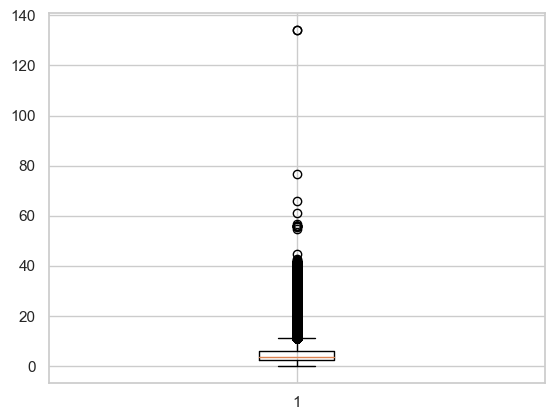

In [198]:
plt.boxplot(sales['sell_price'])
plt.show()

In [199]:
print(prices[prices['sell_price'] > 80])

                        item       category store_code  yearweek  sell_price
6604082  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_3    201320      134.15
6604083  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_3    201321      134.15
6604084  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_3    201322      134.15


In [200]:
print(prices[prices['item'] == 'HOME_&_GARDEN_2_406'])

                        item       category store_code  yearweek  sell_price
347881   HOME_&_GARDEN_2_406  HOME_&_GARDEN      NYC_1    201105     15.5875
347882   HOME_&_GARDEN_2_406  HOME_&_GARDEN      NYC_1    201106     15.5875
347883   HOME_&_GARDEN_2_406  HOME_&_GARDEN      NYC_1    201107     15.5875
347884   HOME_&_GARDEN_2_406  HOME_&_GARDEN      NYC_1    201108     15.5875
347885   HOME_&_GARDEN_2_406  HOME_&_GARDEN      NYC_1    201109     15.5875
...                      ...            ...        ...       ...         ...
6604242  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_3    201617     15.5750
6604243  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_3    201617     15.5750
6604244  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_3    201617     15.5750
6604245  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_3    201617     15.5750
6604246  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_3    201617     15.5750

[2867 rows x 5 columns]


In [201]:
# notadamente temos 3 registros com erros na coluna sell_price. Vamos corrigir esses outliers com um mean dos valores de custo desse item
media_sell_price = np.mean(prices[prices['item'] == 'HOME_&_GARDEN_2_406'].sell_price) #efetua o cálculo da média de preços
prices.loc[prices['sell_price'] > 80, 'sell_price'] = media_sell_price #substitui os valores que são acima de 80 na coluna sell_price
print(prices[prices['sell_price'] > 80]) # imprime os valores maiores para certificar que está correto.

Empty DataFrame
Columns: [item, category, store_code, yearweek, sell_price]
Index: []


In [202]:
print(prices[prices['sell_price'] > 70])

                        item       category store_code  yearweek  sell_price
5910991  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_2    201241      76.825
5910992  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_2    201242      76.825
5910993  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_2    201243      76.825
5910994  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_2    201244      76.825
5910995  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_2    201245      76.825
5910996  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_2    201246      76.825
5910997  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_2    201247      76.825
5910998  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_2    201248      76.825
5910999  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_2    201249      76.825
5911000  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_2    201250      76.825
5911001  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_2    201251      76.825
5911002  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_2    201252      76.825

In [203]:
filtro = (prices['item'] == 'HOME_&_GARDEN_2_406') & (prices['store_code'] == 'PHI_2') #filtra os valores que são iguais a "media_sell_price" item e o código da loja PHI_2
media_sell_price = np.mean(prices[filtro].sell_price) #calcula a média dos valores selecionados anteriormente e armazena em "media_sell_price"
prices.loc[prices['sell_price'] > 70, 'sell_price'] = media_sell_price #substitui os valores maiores que 70 pelo valor da média calculada anteriormente, usando o método "loc"
print(prices[prices['sell_price'] > 70]) #imprime os valores para certificar que está correto.

Empty DataFrame
Columns: [item, category, store_code, yearweek, sell_price]
Index: []


In [204]:
print(prices[prices['sell_price'] > 50])

                        item       category store_code  yearweek  sell_price
3050937  HOME_&_GARDEN_2_178  HOME_&_GARDEN      BOS_1    201229     55.4500
3050938  HOME_&_GARDEN_2_178  HOME_&_GARDEN      BOS_1    201230     55.4500
3050939  HOME_&_GARDEN_2_178  HOME_&_GARDEN      BOS_1    201231     55.4500
3120715  HOME_&_GARDEN_2_466  HOME_&_GARDEN      BOS_1    201223     54.8000
3120727  HOME_&_GARDEN_2_466  HOME_&_GARDEN      BOS_1    201235     56.0500
3120730  HOME_&_GARDEN_2_466  HOME_&_GARDEN      BOS_1    201238     65.7750
3120733  HOME_&_GARDEN_2_466  HOME_&_GARDEN      BOS_1    201241     56.0500
3120738  HOME_&_GARDEN_2_466  HOME_&_GARDEN      BOS_1    201246     56.0500
3120739  HOME_&_GARDEN_2_466  HOME_&_GARDEN      BOS_1    201247     56.0500
3120740  HOME_&_GARDEN_2_466  HOME_&_GARDEN      BOS_1    201248     56.0500
3120741  HOME_&_GARDEN_2_466  HOME_&_GARDEN      BOS_1    201249     56.0500
3120742  HOME_&_GARDEN_2_466  HOME_&_GARDEN      BOS_1    201250     56.0500

In [205]:
filtro = (prices['item'] == 'HOME_&_GARDEN_2_178') & (prices['store_code'] == 'BOS_1') #filtrando os dados com o item iguaç a "HOME_&_GARDEN_2_178" e o código da loja "BOS_1"
media_sell_price = np.mean(prices[filtro].sell_price) #efetua o cálculo da média dos preços de venda desses itens selecionados e guarda em média_sell_price
prices.loc[(prices['sell_price'] > 50) & (prices['item'] == 'HOME_&_GARDEN_2_178') & (prices['store_code'] == 'BOS_1'), 'sell_price'] = media_sell_price #atualiza os preços na coluna
print(prices[prices['sell_price'] > 50]) #efetua uma visualização para confirmar se está ok.

                        item       category store_code  yearweek  sell_price
3120715  HOME_&_GARDEN_2_466  HOME_&_GARDEN      BOS_1    201223     54.8000
3120727  HOME_&_GARDEN_2_466  HOME_&_GARDEN      BOS_1    201235     56.0500
3120730  HOME_&_GARDEN_2_466  HOME_&_GARDEN      BOS_1    201238     65.7750
3120733  HOME_&_GARDEN_2_466  HOME_&_GARDEN      BOS_1    201241     56.0500
3120738  HOME_&_GARDEN_2_466  HOME_&_GARDEN      BOS_1    201246     56.0500
3120739  HOME_&_GARDEN_2_466  HOME_&_GARDEN      BOS_1    201247     56.0500
3120740  HOME_&_GARDEN_2_466  HOME_&_GARDEN      BOS_1    201248     56.0500
3120741  HOME_&_GARDEN_2_466  HOME_&_GARDEN      BOS_1    201249     56.0500
3120742  HOME_&_GARDEN_2_466  HOME_&_GARDEN      BOS_1    201250     56.0500
3120743  HOME_&_GARDEN_2_466  HOME_&_GARDEN      BOS_1    201251     56.0500
3120744  HOME_&_GARDEN_2_466  HOME_&_GARDEN      BOS_1    201252     56.0500
3120745  HOME_&_GARDEN_2_466  HOME_&_GARDEN      BOS_1    201253     56.0500

In [206]:
filtro = (prices['item'] == 'HOME_&_GARDEN_2_466') & (prices['store_code'] == 'BOS_1')
media_sell_price = np.mean(prices[filtro].sell_price)
prices.loc[(prices['sell_price'] > 50) & (prices['item'] == 'HOME_&_GARDEN_2_466') & (prices['store_code'] == 'BOS_1'), 'sell_price'] = media_sell_price
print(prices[prices['sell_price'] > 50])

                        item       category store_code  yearweek  sell_price
5910960  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_2    201210     54.9875
5910961  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_2    201211     54.9875
5910962  HOME_&_GARDEN_2_406  HOME_&_GARDEN      PHI_2    201212     54.9875


In [207]:
filtro = (prices['item'] == 'HOME_&_GARDEN_2_406') & (prices['store_code'] == 'PHI_2')
media_sell_price = np.mean(prices[filtro].sell_price)
prices.loc[(prices['sell_price'] > 50) & (prices['item'] == 'HOME_&_GARDEN_2_406') & (prices['store_code'] == 'PHI_2'), 'sell_price'] = media_sell_price
print(prices[prices['sell_price'] > 50])

Empty DataFrame
Columns: [item, category, store_code, yearweek, sell_price]
Index: []


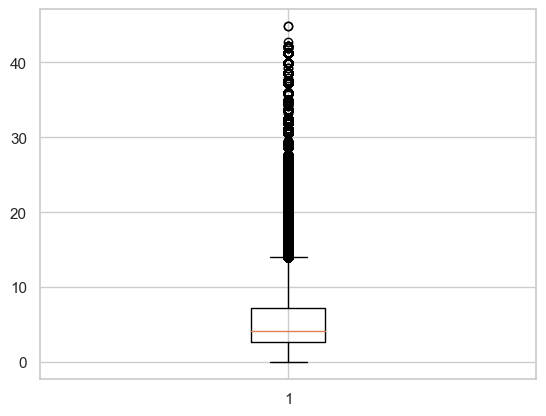

In [208]:
plt.boxplot(prices['sell_price'])
plt.show()

## Perfil dos Dados

In [ ]:
# Crie o perfil do DataFrame
profile = ProfileReport(sales)

# Gere o relatório
profile.to_file("relatorio_sales.html")

## Plotagem dos dados

In [135]:
#Utilizando o Power BI  para gerar os gráficos.

In [78]:
# Set new width and height for the container
#PBI_visualize.set_size(400, 600)

In [79]:
# Create a Power BI report from your data
#PBI_visualize = QuickVisualize(get_dataset_config(sales), auth=device_auth)

# Render new report
#PBI_visualize

In [209]:
sales.head()

date  yearweek store_code              store    region  \
0 2011-01-30    201105      NYC_1  Greenwich_Village  New York   
1 2011-02-03    201105      NYC_1  Greenwich_Village  New York   
2 2011-02-04    201105      NYC_1  Greenwich_Village  New York   
3 2011-02-05    201105      NYC_1  Greenwich_Village  New York   
4 2011-01-30    201105      NYC_1  Greenwich_Village  New York   

               item  dia  qtd  sell_price    category  valor_total  
0  ACCESORIES_1_008  d_2   15      0.6118  ACCESORIES       9.1770  
1  ACCESORIES_1_008  d_6    4      0.6118  ACCESORIES       2.4472  
2  ACCESORIES_1_008  d_7    6      0.6118  ACCESORIES       3.6708  
3  ACCESORIES_1_008  d_8    5      0.6118  ACCESORIES       3.0590  
4  ACCESORIES_1_012  d_2    2      7.9534  ACCESORIES      15.9068

### Criação de dashboards para análise geral


O código abaixo serve para adicionar duas novas colunas ao dataframe sales_data: "year" e "yearmonth", com base na coluna existente "date".

A primeira linha, sales_data['year'] = sales_data.date.dt.year, extrai o ano da coluna "date" e atribui os valores resultantes à nova coluna "year". O método dt.year é aplicado à coluna "date" para obter o componente do ano.

A segunda linha, sales_data['yearmonth'] = sales_data['date'].apply(lambda x: x.strftime('%Y-%m')), extrai o ano e o mês da coluna "date" e atribui os valores resultantes à nova coluna "yearmonth". A função apply é usada juntamente com uma expressão lambda para aplicar a função strftime('%Y-%m') em cada valor da coluna "date", convertendo a data para o formato string "YYYY-MM" (ano e mês).


In [210]:
"""
sales_data = sales
sales_data['year'] = sales_data.date.dt.year
# Extrair o ano e o mês em formato string em uma nova coluna
sales_data['yearmonth'] = sales_data['date'].apply(lambda x: x.strftime('%Y-%m'))
"""
sales_data = sales
sales_data['yearmonth'] = sales_data['date'].dt.to_period('M').astype(str)



In [211]:
sales_data.head()

date  yearweek store_code              store    region  \
0 2011-01-30    201105      NYC_1  Greenwich_Village  New York   
1 2011-02-03    201105      NYC_1  Greenwich_Village  New York   
2 2011-02-04    201105      NYC_1  Greenwich_Village  New York   
3 2011-02-05    201105      NYC_1  Greenwich_Village  New York   
4 2011-01-30    201105      NYC_1  Greenwich_Village  New York   

               item  dia  qtd  sell_price    category  valor_total yearmonth  
0  ACCESORIES_1_008  d_2   15      0.6118  ACCESORIES       9.1770   2011-01  
1  ACCESORIES_1_008  d_6    4      0.6118  ACCESORIES       2.4472   2011-02  
2  ACCESORIES_1_008  d_7    6      0.6118  ACCESORIES       3.6708   2011-02  
3  ACCESORIES_1_008  d_8    5      0.6118  ACCESORIES       3.0590   2011-02  
4  ACCESORIES_1_012  d_2    2      7.9534  ACCESORIES      15.9068   2011-01

In [212]:
sales_data.dtypes

date           datetime64[ns]
yearweek                int32
store_code             object
store                  object
region                 object
item                   object
dia                    object
qtd                     int64
sell_price            float64
category               object
valor_total           float64
yearmonth              object
dtype: object

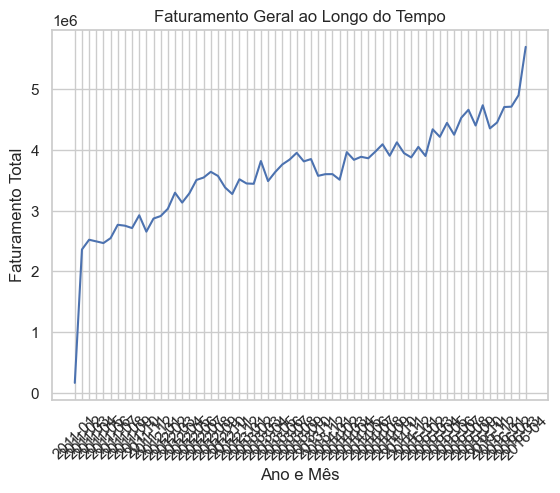

In [213]:
# Dashboard 1: Faturamento Geral ao longo do tempo
#fig1 = px.line(sales_data, x='yearmonth', y='valor_total', title='Faturamento Geral ao longo do tempo')
#fig1.show()

# Agrupar os dados por ano e mês e calcular o faturamento total
faturamento_por_mes = sales_data.groupby('yearmonth')['valor_total'].sum()

# Criar o gráfico de linhas
plt.plot(faturamento_por_mes.index, faturamento_por_mes.values)
plt.xlabel('Ano e Mês')
plt.ylabel('Faturamento Total')
plt.title('Faturamento Geral ao Longo do Tempo')
plt.xticks(rotation=45)
plt.show()

In [214]:
# Dashboard 2: Faturamento por Loja

fig2 = px.bar(sales_data, x='store', y='valor_total', title='Faturamento por Loja')
fig2.show()


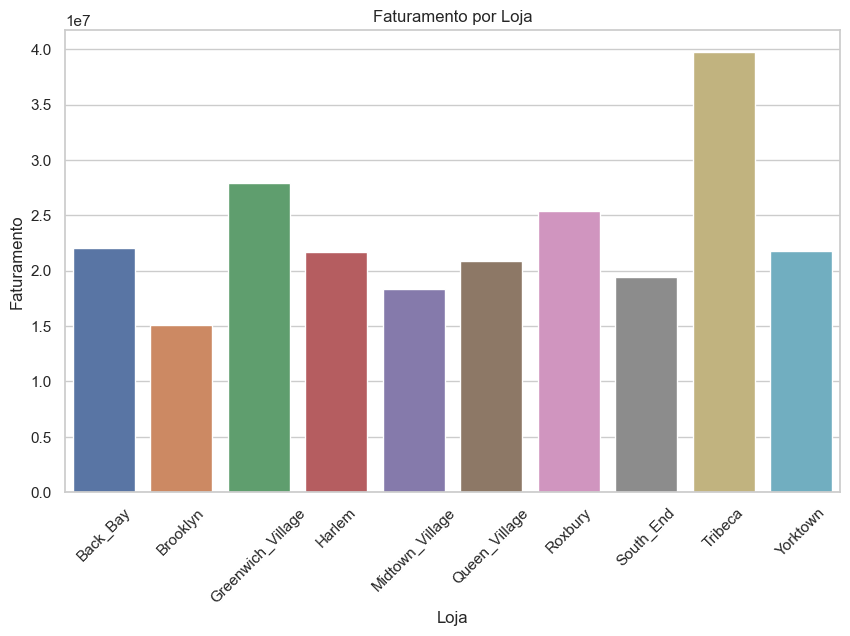

In [215]:
# Dashboard 2: Faturamento por Loja
import seaborn as sns

# Agrupar o dataframe por loja e calcular o faturamento total
faturamento_por_loja = sales_data.groupby('store')['valor_total'].sum().reset_index()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='store', y='valor_total', data=faturamento_por_loja)
plt.title('Faturamento por Loja')
plt.xlabel('Loja')
plt.ylabel('Faturamento')
plt.xticks(rotation=45)
plt.show()


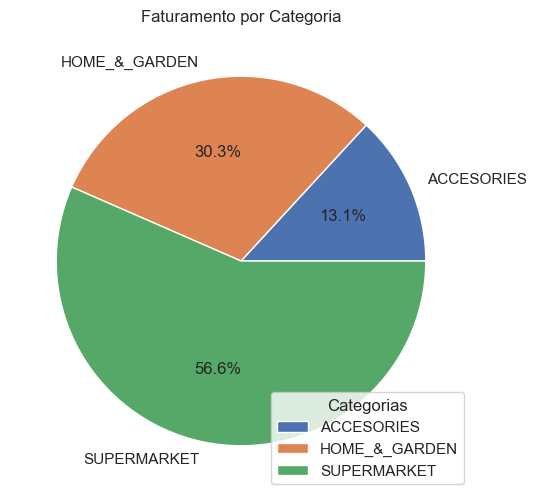

In [216]:
# Dashboard 3: Faturamento por Categoria

#fig3 = px.pie(sales_data, names='category', values='valor_total', title='Faturamento por Categoria')
#fig3.show()

# Agrupar o dataframe por categoria e calcular o faturamento total
faturamento_por_categoria = sales_data.groupby('category')['valor_total'].sum().reset_index()

# Configurar o estilo do gráfico
sns.set(style='whitegrid')

# Criar o gráfico de pizza
plt.figure(figsize=(8, 6))
plt.pie(faturamento_por_categoria['valor_total'], labels=faturamento_por_categoria['category'], autopct='%1.1f%%')
plt.title('Faturamento por Categoria')

# Adicionar legenda
plt.legend(title='Categorias', loc='lower right')

# Exibir o gráfico
plt.show()

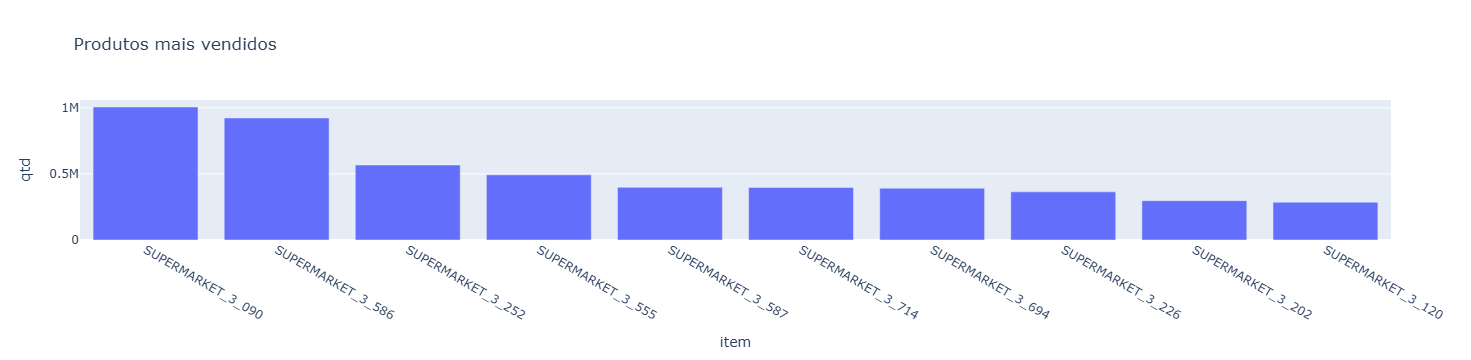

In [217]:
# Dashboard 4: Produtos mais vendidos
top_products = sales_data.groupby('item')['qtd'].sum().nlargest(10).reset_index()
fig4 = px.bar(top_products, x='item', y='qtd', title='Produtos mais vendidos')
fig4.show()

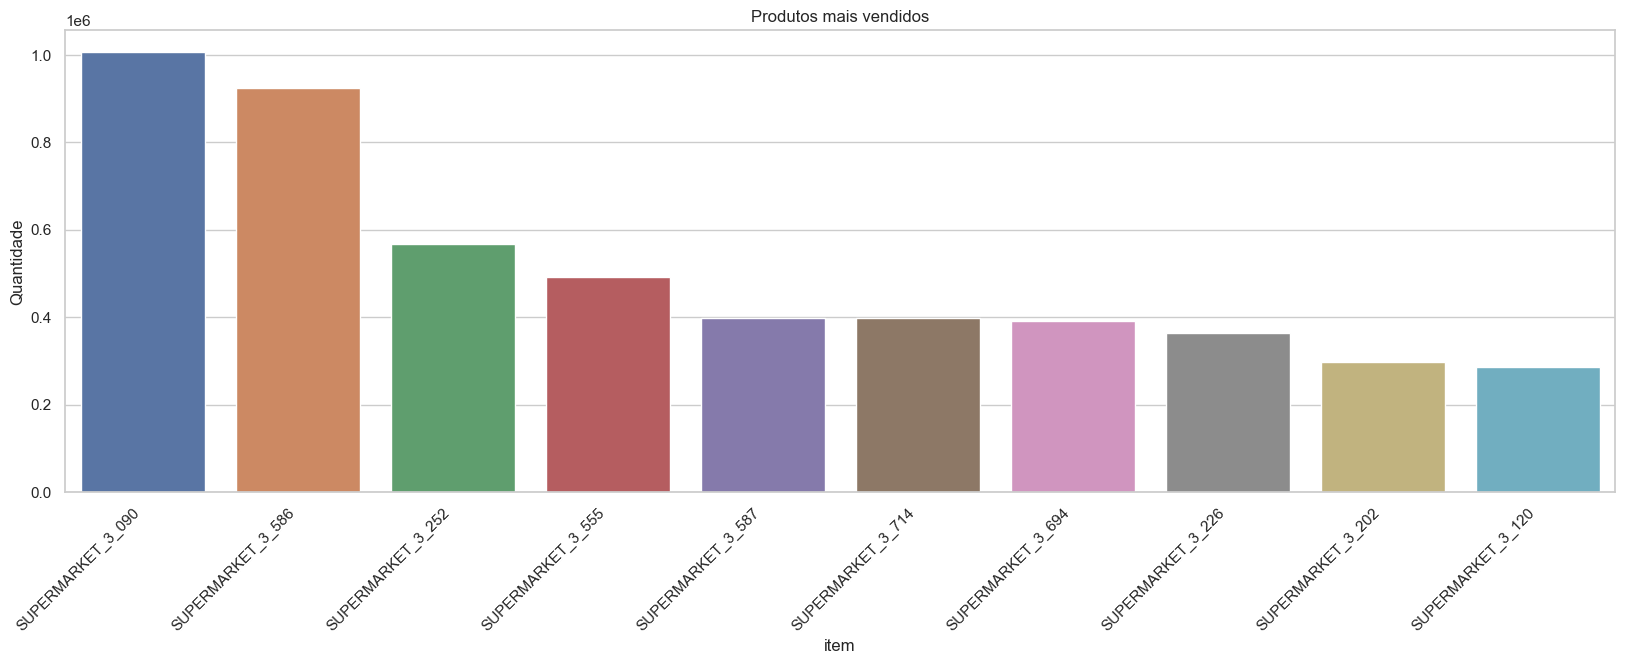

In [218]:
# Dashboard 4: Produtos mais vendidos
# Agrupar os produtos mais vendidos
top_products = sales_data.groupby('item')['qtd'].sum().nlargest(10).reset_index()

# Gráfico de barras
plt.figure(figsize=(20, 6))
sns.barplot(x='item', y='qtd', data=top_products)
plt.title('Produtos mais vendidos')
plt.ylabel('Quantidade')

# Rotacionar os rótulos do eixo x para melhor visualização
plt.xticks(rotation=45, ha='right')

# Exibir o gráfico
plt.show()


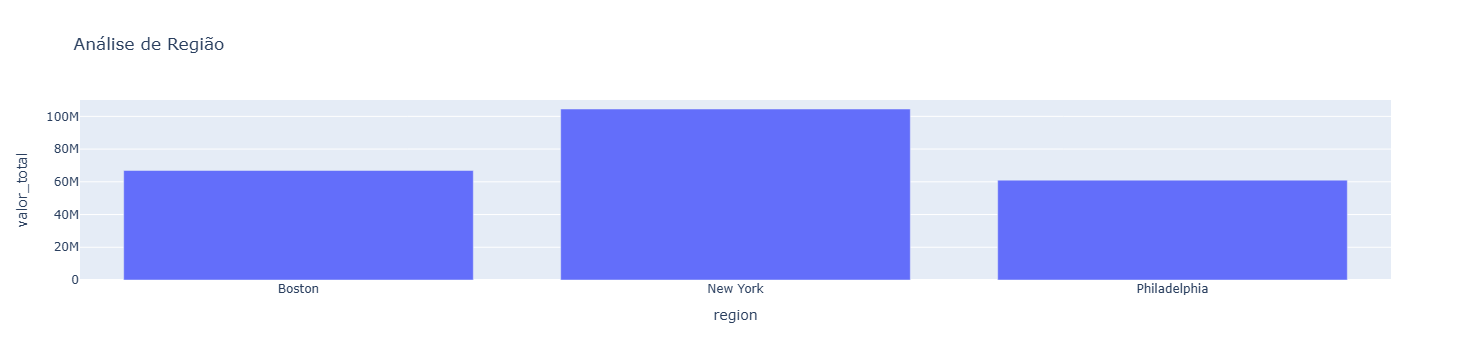

In [219]:
# Dashboard 5: Análise de Região
region_sales = sales_data.groupby('region')['valor_total'].sum().reset_index()
fig5 = px.bar(region_sales, x='region', y='valor_total', title='Análise de Região')
fig5.show()

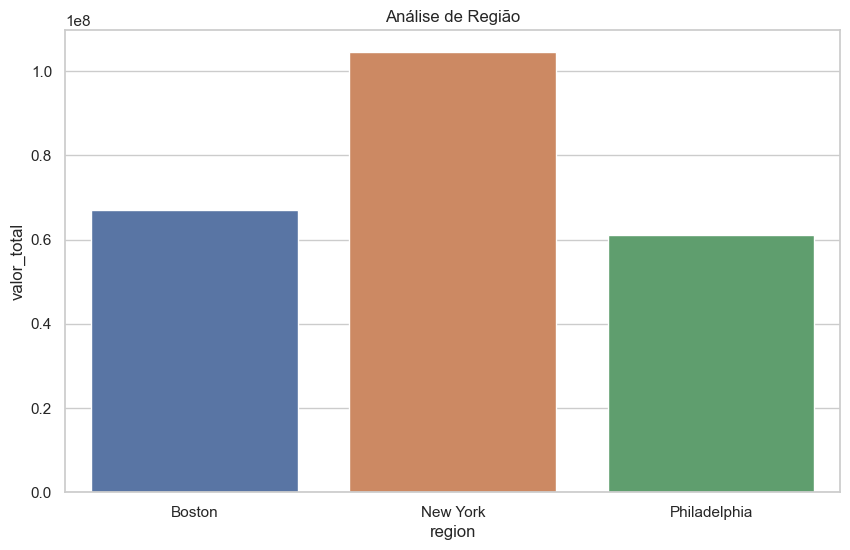

In [220]:
# Dashboard 5: Análise de Região
# Gráfico de barras
region_sales = sales_data.groupby('region')['valor_total'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='region', y='valor_total', data=region_sales)
plt.title('Análise de Região')

# Exibir o gráfico
plt.show()

### Criação de dashboards para análise do negócio

#### Gráficos mostrando as vendas por categorias por ano nas lojas da rede

In [233]:
# Agrupar por loja, ano e categoria as métricas de popularidade
category_popularity = sales_data.groupby(['store', 'year', 'category'])['qtd'].sum()

# Resetar o índice para que 'store', 'year' e 'category' se tornem colunas do DataFrame
category_popularity = category_popularity.reset_index()

# Gráfico de barras das quantidades de vendas por store, year e category
fig = px.bar(category_popularity, x='store', y='qtd', color='year', facet_col='category',
             facet_col_wrap=20, title='Quantidades de Vendas por Store, Year e Category')

fig.show()

KeyError: 'year'

In [234]:
# Gráfico de barras das quantidades de vendas por store, year e category
fig = px.bar(category_popularity, x='category', y='qtd', color='year', facet_col='store',
             facet_col_wrap=20, title='Quantidades de Vendas por Store, Year e Category')

fig.show()

NameError: name 'category_popularity' is not defined

#### Analisar a variação de menos popularidade dos produtos entre cidades ou lojas (DOWN 5):

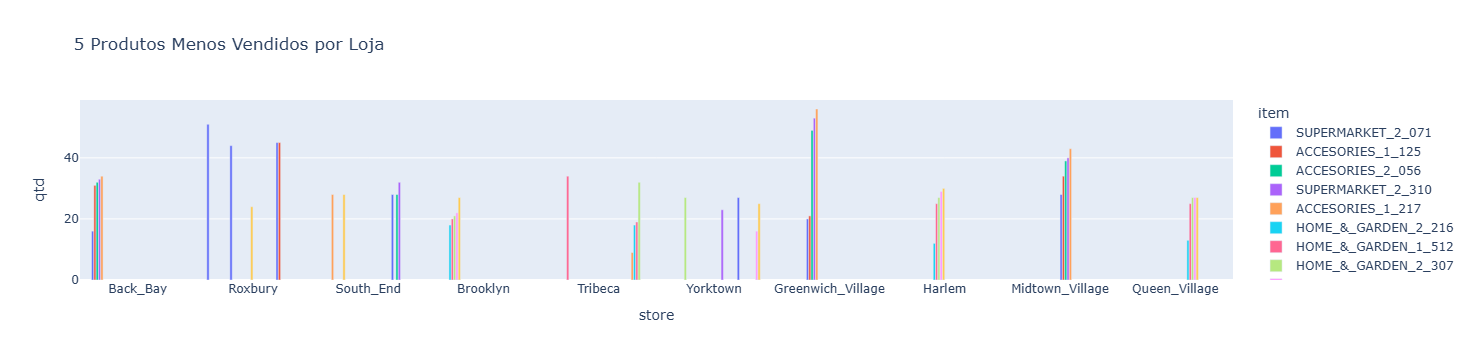

In [235]:
# Agrupar por loja e produto e calcular as métricas de vendas (quantidade vendida)
product_sales_by_store = sales_data.groupby(['store', 'item'])['qtd'].sum()

# Resetar o índice para que 'store' e 'item' se tornem colunas do DataFrame
product_sales_by_store = product_sales_by_store.reset_index()

# Obter os 5 produtos menos vendidos por loja
bottom_products_by_store = product_sales_by_store.groupby('store').apply(lambda x: x.nsmallest(5, 'qtd')).reset_index(drop=True)

# Plotar os 5 produtos menos vendidos por loja
fig = px.bar(bottom_products_by_store, x='store', y='qtd', color='item',
             title='5 Produtos Menos Vendidos por Loja', barmode='group')

fig.show()

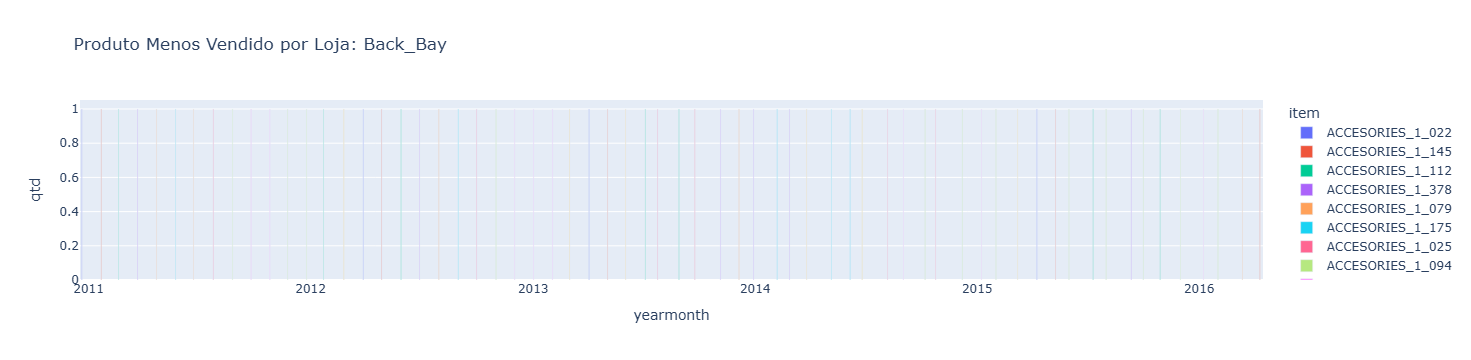

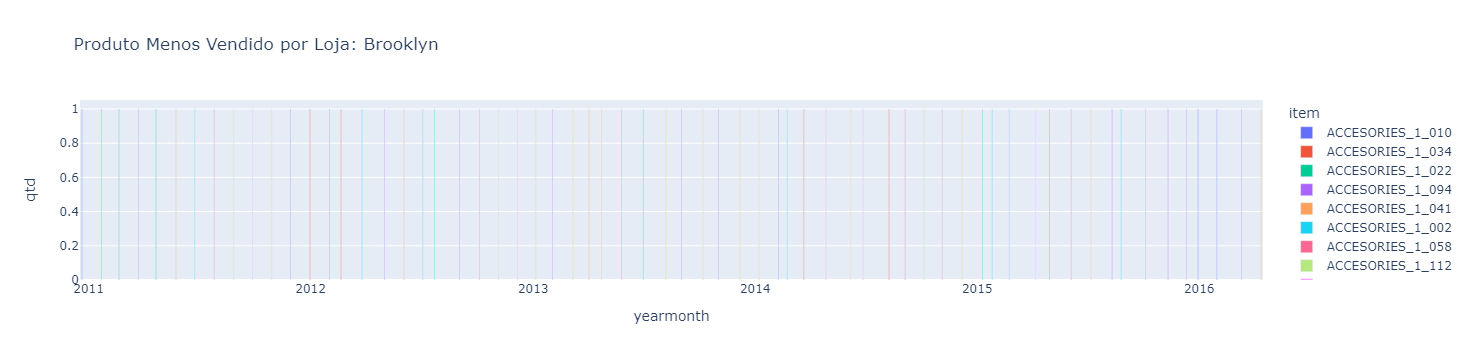

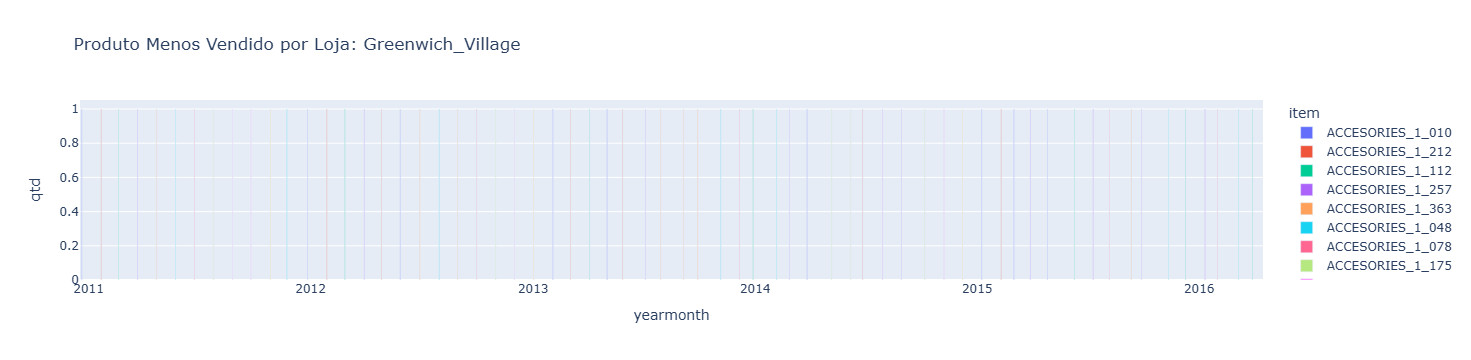

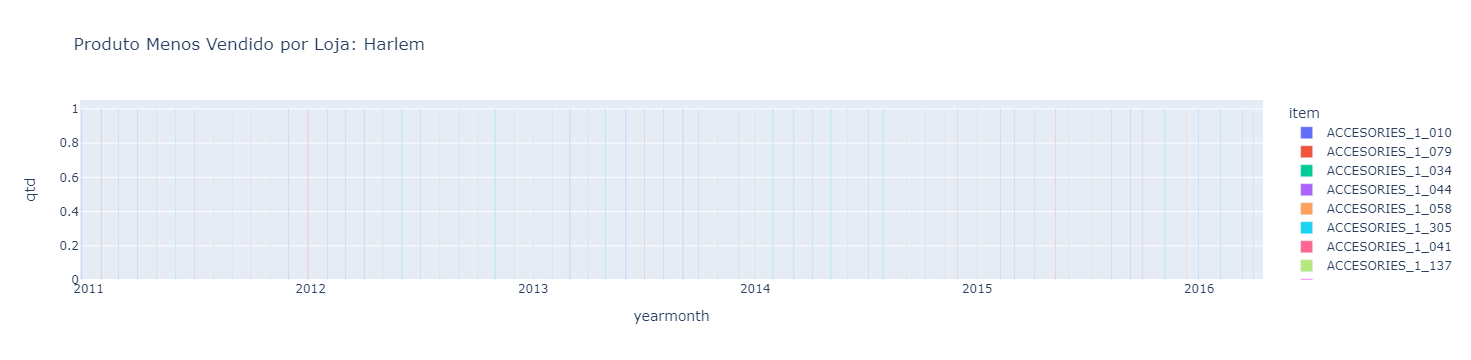

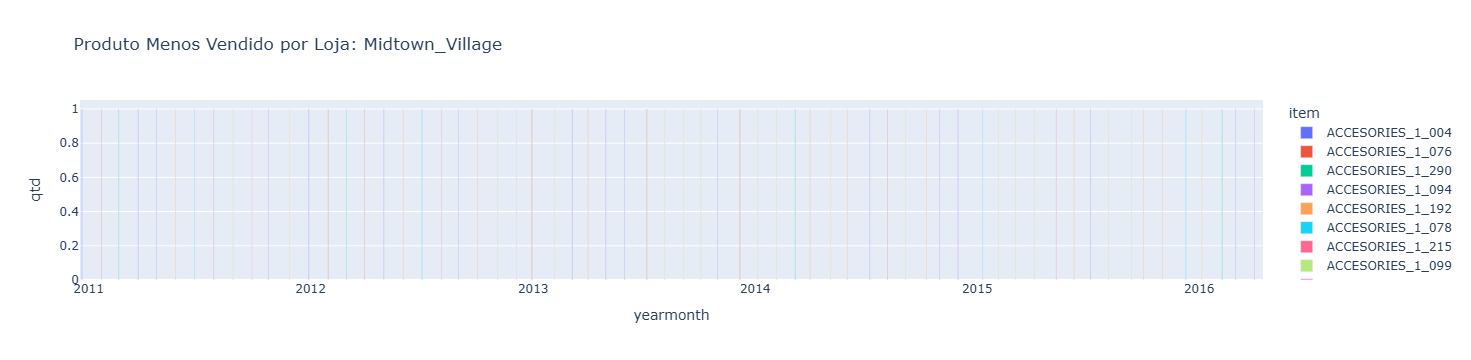

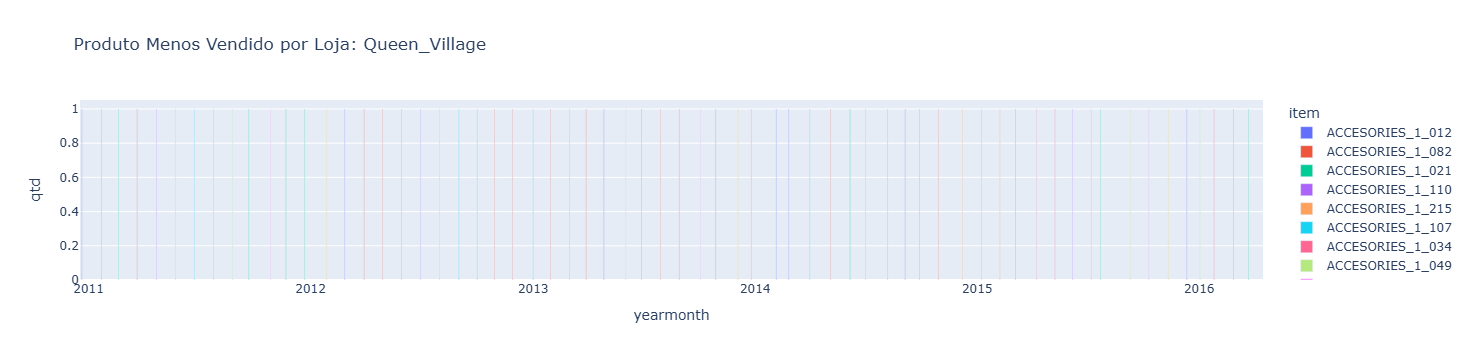

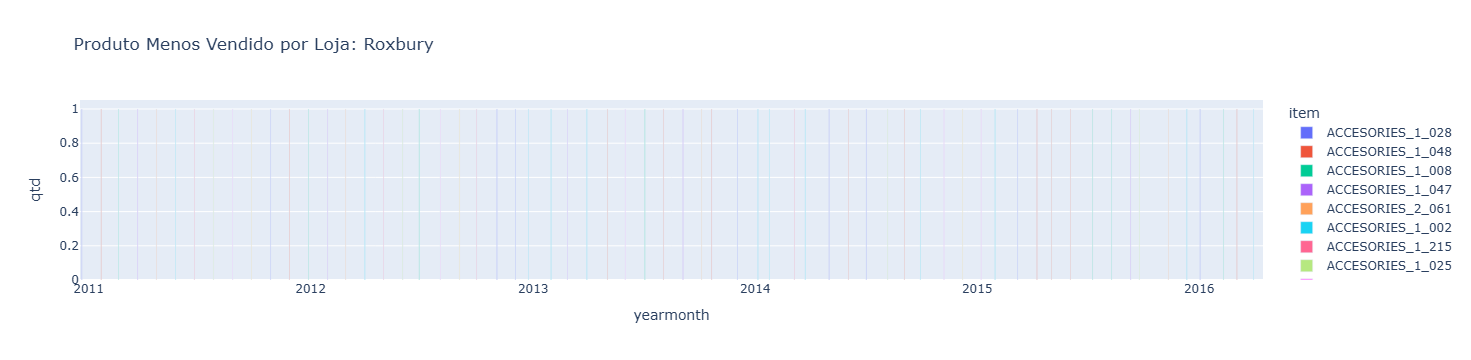

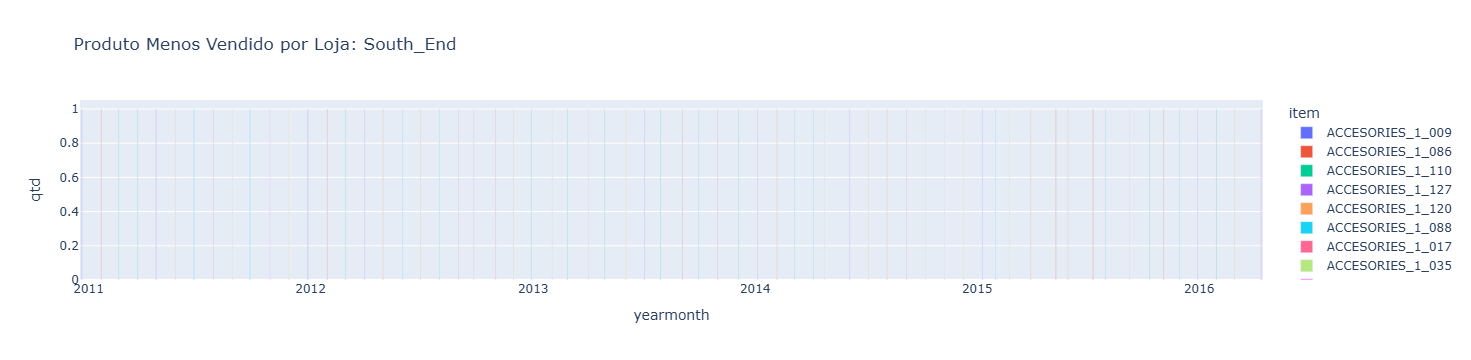

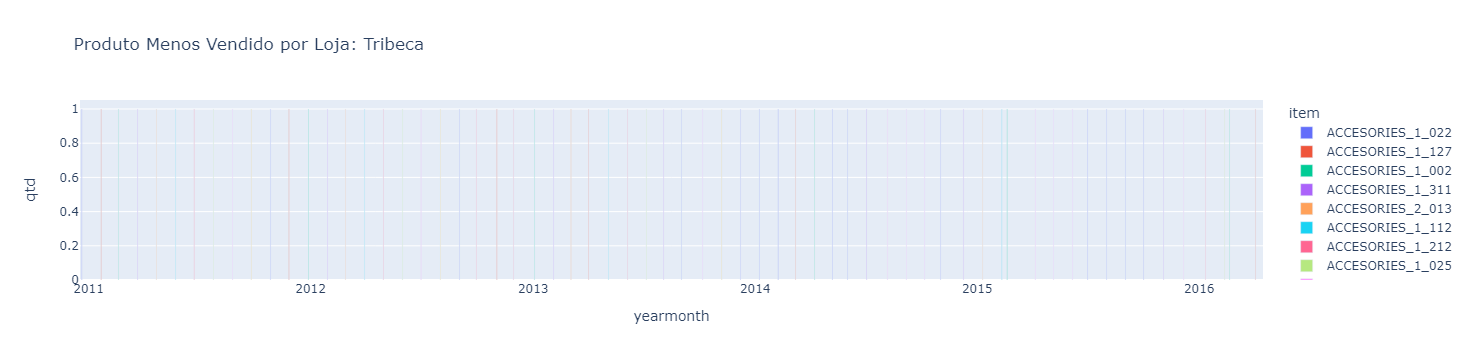

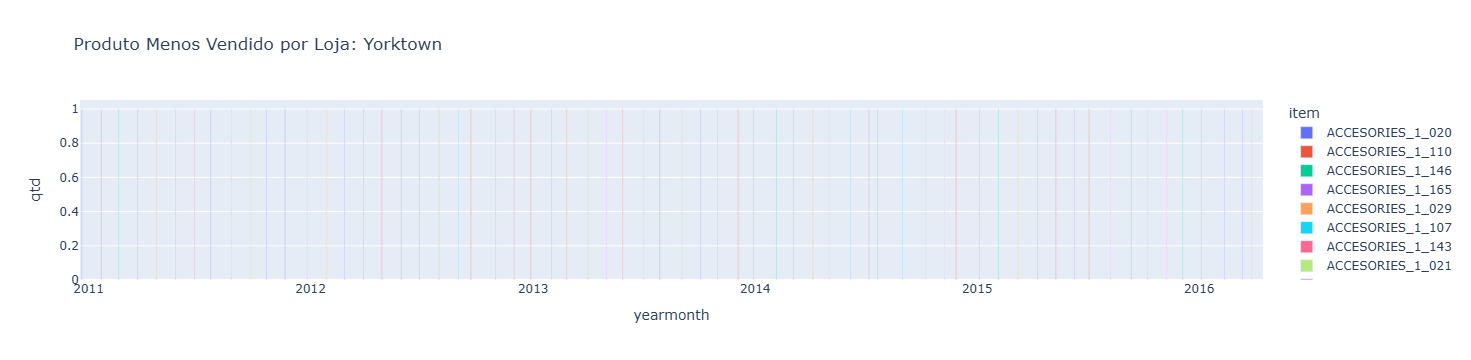

In [236]:
# Agrupar por loja, produto e yearmonth e calcular as métricas de vendas (quantidade vendida)
product_sales_by_store = sales_data.groupby(['store', 'item', 'yearmonth'])['qtd'].sum()

# Resetar o índice para que 'store', 'item' e 'yearmonth' se tornem colunas do DataFrame
product_sales_by_store = product_sales_by_store.reset_index()

# Obter o produto menos vendido por loja em cada yearmonth
bottom_product_by_store = product_sales_by_store.groupby(['store', 'yearmonth']).apply(lambda x: x.nsmallest(1, 'qtd')).reset_index(drop=True)

# Plotar as informações individualmente para cada loja
for store in bottom_product_by_store['store'].unique():
    store_data = bottom_product_by_store[bottom_product_by_store['store'] == store]
    fig = px.bar(store_data, x='yearmonth', y='qtd', color='item',
                 title=f"Produto Menos Vendido por Loja: {store}", barmode='group')
    fig.show()

#### Analisar a variação de popularidade dos produtos entre cidades ou lojas (TOP 5):

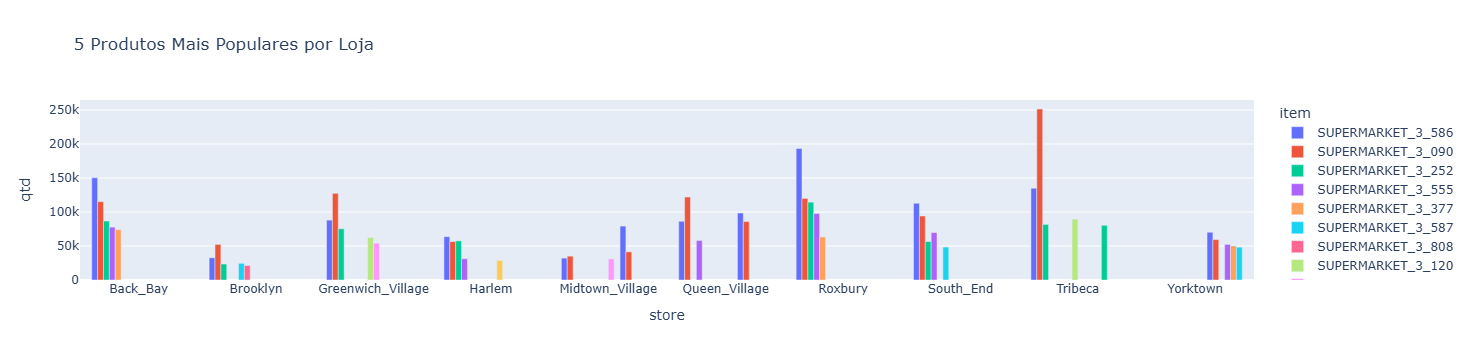

In [237]:
# Agrupar por loja e produto e calcular as métricas de popularidade (quantidade vendida)
product_popularity_by_store = sales_data.groupby(['store', 'item'])['qtd'].sum()

# Resetar o índice para que 'store' e 'item' se tornem colunas do DataFrame
product_popularity_by_store = product_popularity_by_store.reset_index()

# Obter os 5 produtos mais populares por loja
top_products_by_store = product_popularity_by_store.groupby('store').apply(lambda x: x.nlargest(5, 'qtd')).reset_index(drop=True)

# Plotar os 5 produtos mais populares por loja
fig = px.bar(top_products_by_store, x='store', y='qtd', color='item',
             title='5 Produtos Mais Populares por Loja', barmode='group')

fig.show()

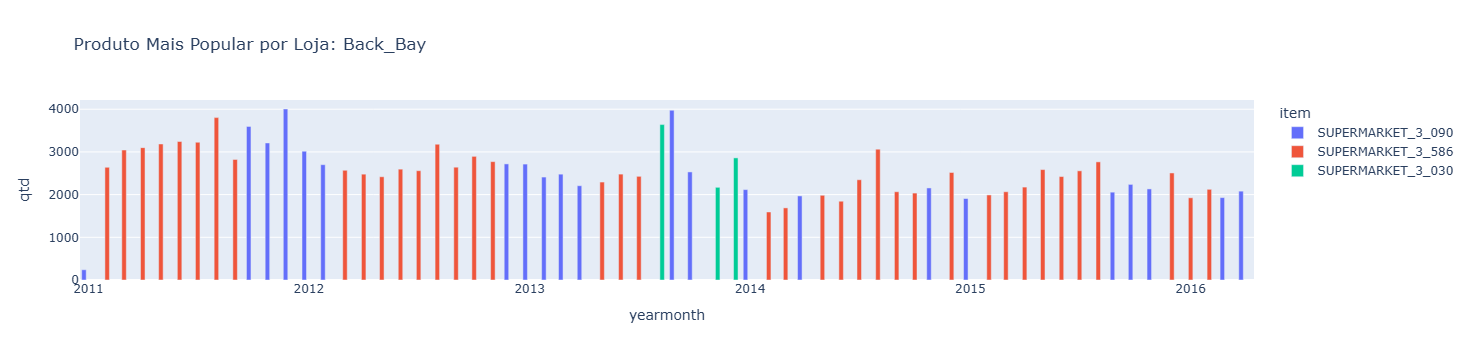

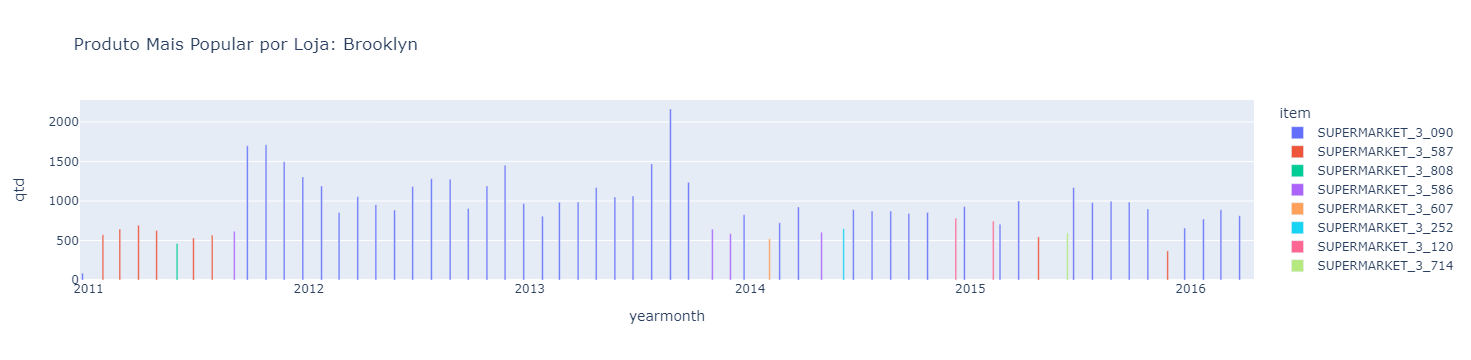

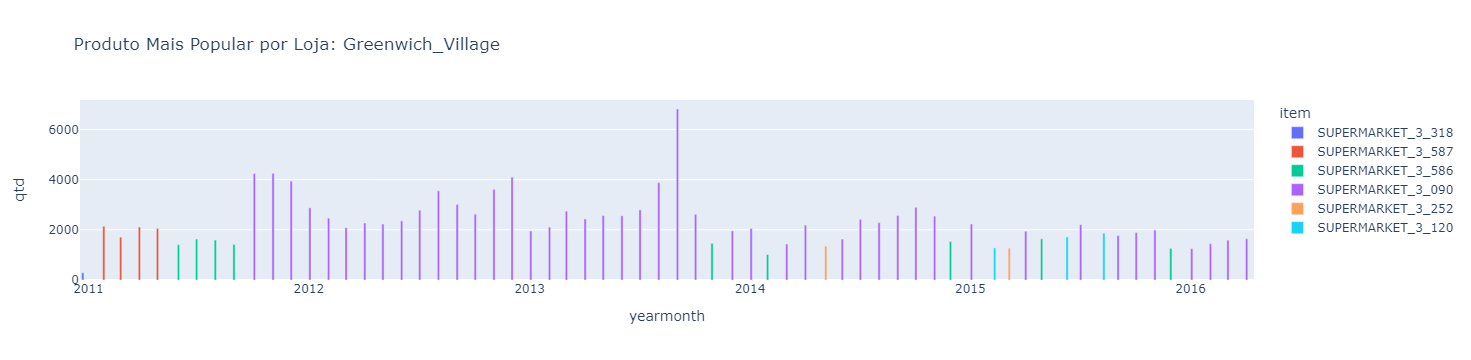

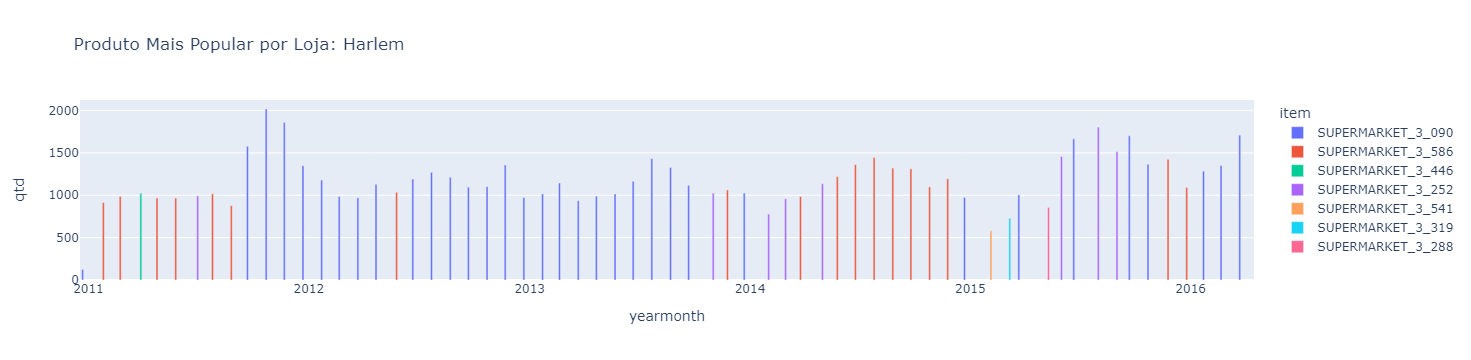

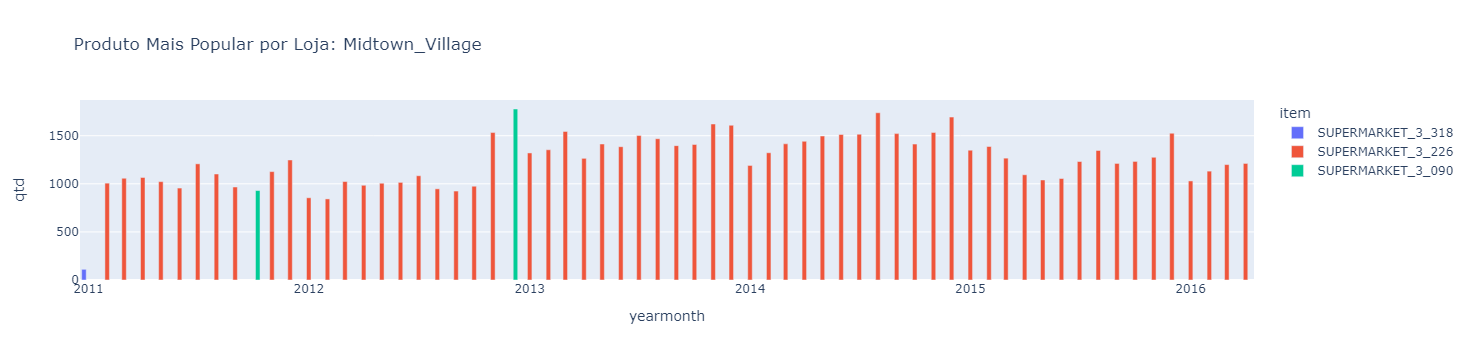

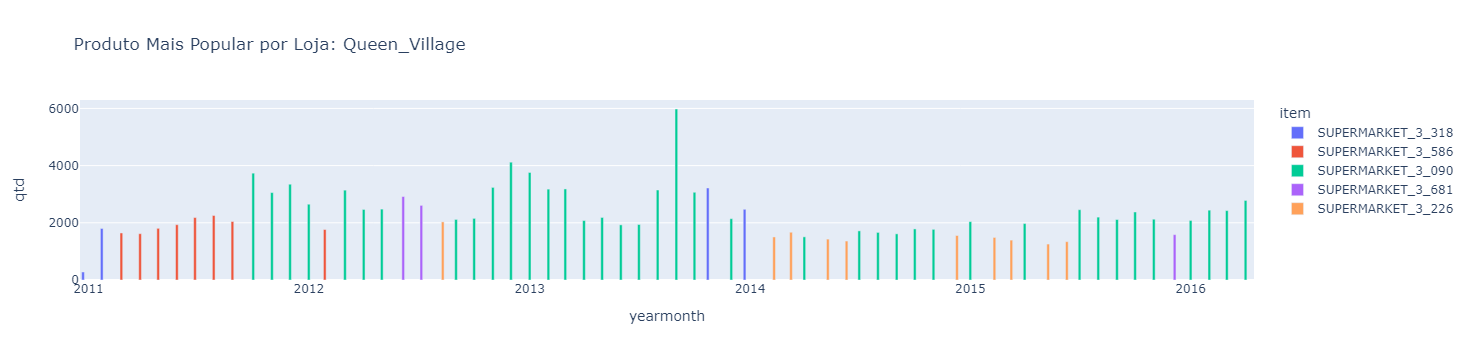

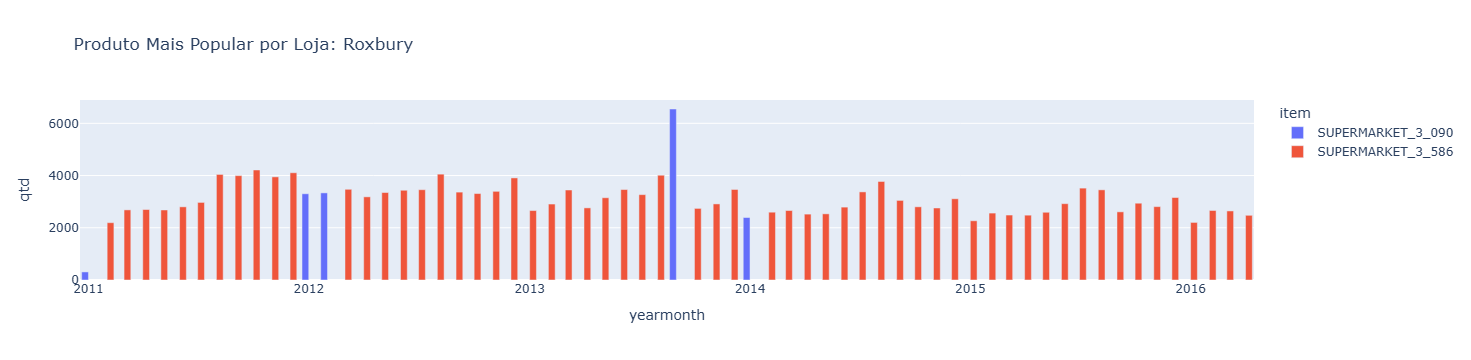

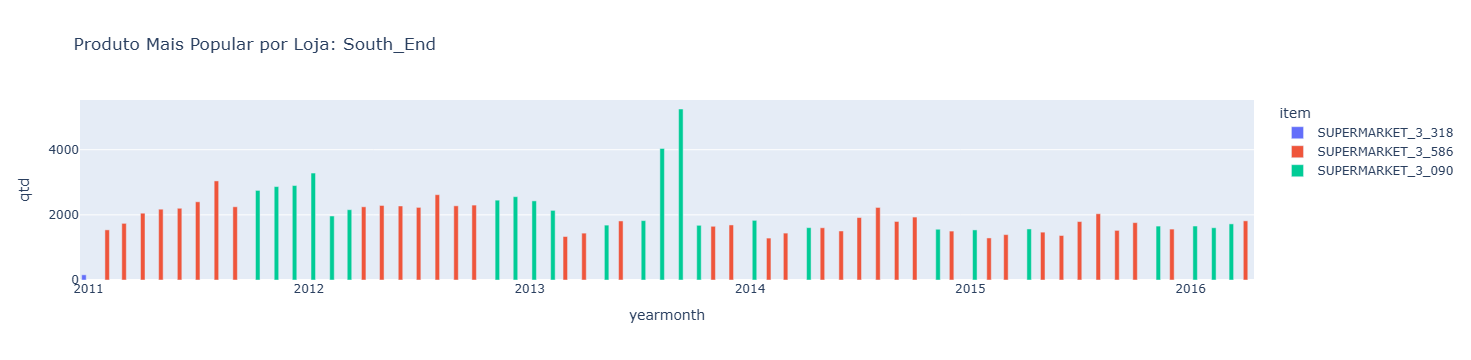

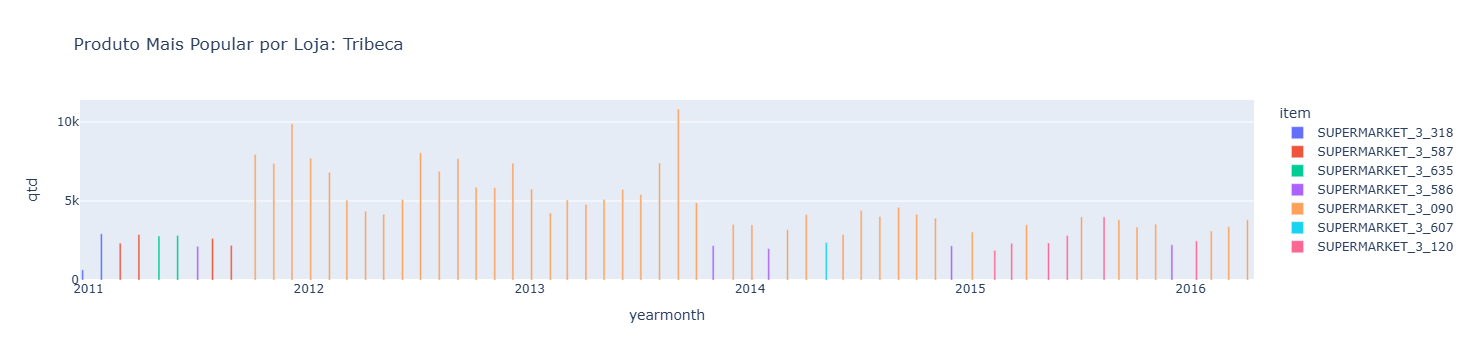

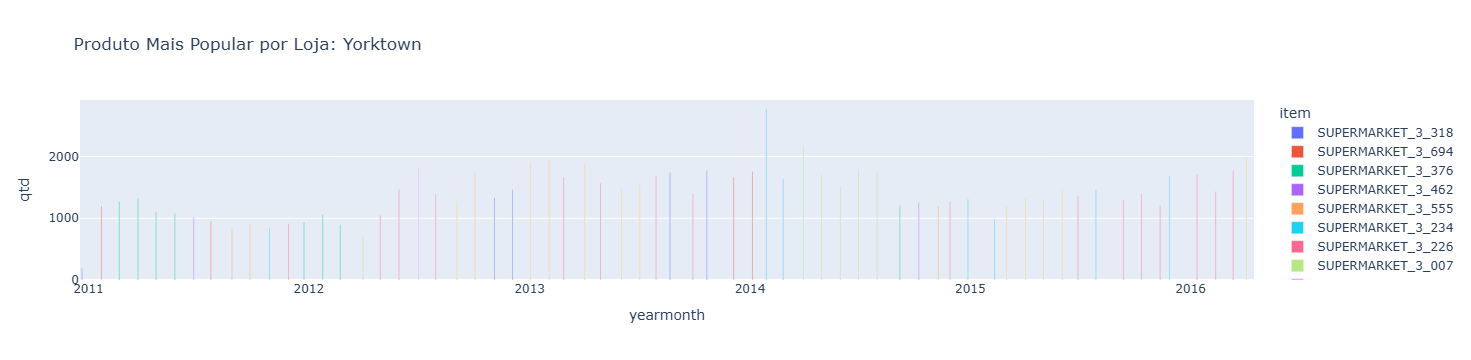

In [238]:
# Agrupar por loja, produto e yearmonth e calcular as métricas de popularidade (quantidade vendida)
product_popularity_by_store = sales_data.groupby(['store', 'item', 'yearmonth'])['qtd'].sum()

# Resetar o índice para que 'store', 'item' e 'yearmonth' se tornem colunas do DataFrame
product_popularity_by_store = product_popularity_by_store.reset_index()

# Obter o produto mais popular por loja em cada yearmonth
top_product_by_store = product_popularity_by_store.groupby(['store', 'yearmonth']).apply(lambda x: x.nlargest(1, 'qtd')).reset_index(drop=True)

# Plotar as informações individualmente para cada loja
for store in top_product_by_store['store'].unique():
    store_data = top_product_by_store[top_product_by_store['store'] == store]
    fig = px.bar(store_data, x='yearmonth', y='qtd', color='item',
                 title=f"Produto Mais Popular por Loja: {store}", barmode='group')
    fig.show()

#### Maiores diferenças atuais de preço

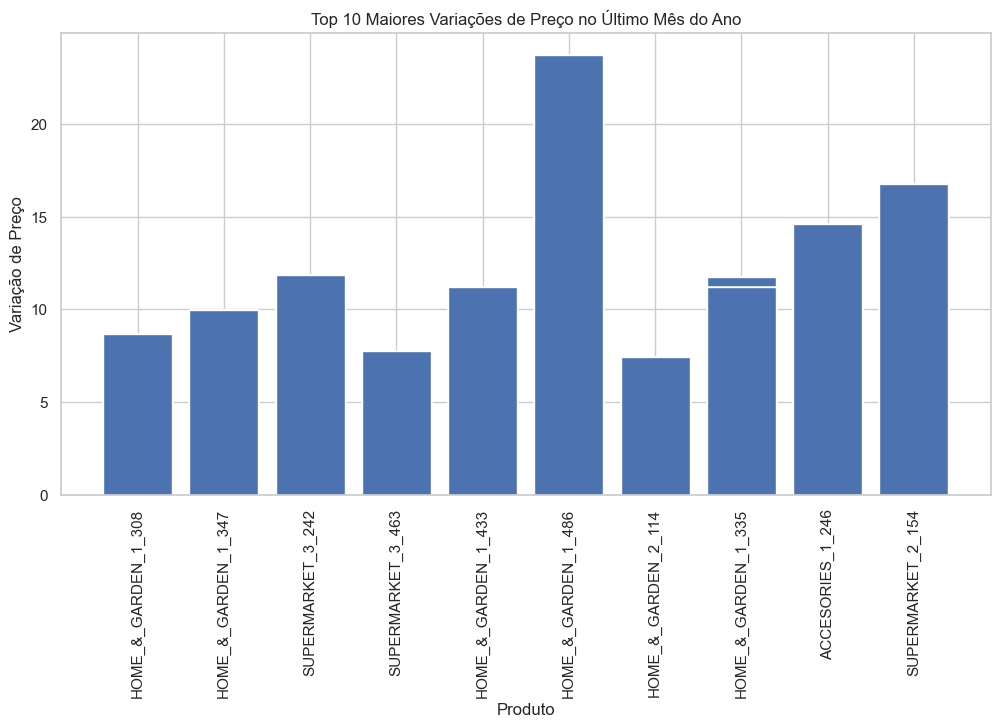

In [239]:
# Filtrar o dataset para o último mês do ano
last_month_year = sales_data['yearmonth'].max()
filtered_data = sales_data[sales_data['yearmonth'] == last_month_year]

# Agrupar por produto e calcular a variação de preço entre as lojas
price_variation_by_product = filtered_data.groupby('item')['sell_price'].max() - filtered_data.groupby('item')['sell_price'].min()

# Obter as 10 maiores variações de preço
top_variations = price_variation_by_product.nlargest(10)

# Obter os produtos correspondentes às maiores variações
top_products = filtered_data[filtered_data['item'].isin(top_variations.index)]

# Plotar o gráfico de barras para as maiores variações
plt.figure(figsize=(12, 6))
plt.bar(top_products['item'], top_products['sell_price'])
plt.xlabel('Produto')
plt.ylabel('Variação de Preço')
plt.title('Top 10 Maiores Variações de Preço no Último Mês do Ano')
plt.xticks(rotation=90)
plt.show()

## Previsões
Serão analisados as previsões das vendas para o reposição dos principais produtos das lojas
 Após será analisado as quantidades (qtd) com as dimensões "store" e "region" para estabelecer relação entre as quantidades e estas dimensões.


AttributeError: 'Series' object has no attribute 'resemple'

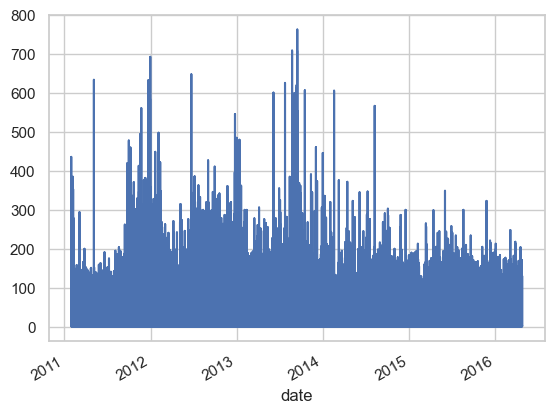

In [240]:
series = pd.Series(sales['qtd'])
series.index = pd.to_datetime(sales['date'])
series.plot()
series.resemple('yearweek').mean().plot()

In [241]:
from pmdarima.arima import ndiffs, nsdiffs

# testes para tendencia
ndiffs(series, test='date')
ndiffs(series, test='yearweek')
series.plot()

ValueError: key must be a string in one in {'kpss': <class 'pmdarima.arima.stationarity.KPSSTest'>, 'adf': <class 'pmdarima.arima.stationarity.ADFTest'>, 'pp': <class 'pmdarima.arima.stationarity.PPTest'>}, but got 'date'

In [242]:
# testes para sazonalidade
nsdiffs(series, test='date', m=4)
nsdiffs(series, test='yearweeek', m=4)

?series.diff
series.plot()

ValueError: key must be a string in one in {'ocsb': <class 'pmdarima.arima.seasonality.OCSBTest'>, 'ch': <class 'pmdarima.arima.seasonality.CHTest'>}, but got 'date'

<AxesSubplot:xlabel='date'>

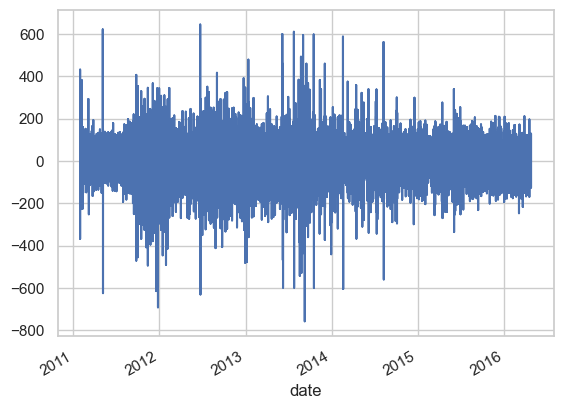

In [243]:
# removendo a tendencia
series.diff(periods=1).plot()

In [12]:
# removendo a sazonalidade
series.diff(periods=4).plot()

NameError: name 'series' is not defined

In [13]:
# residuos
series.diff(periods=1).diff(periods=4).plot()

NameError: name 'series' is not defined

In [14]:
# dados em falta
series_with_nan = series.copy()

idx = np.random.choice(range(len(series)), size=50, replace=False)

series_with_nan[idx] = np.nan

series_with_nan.plot()

NameError: name 'series' is not defined

In [15]:
# auto arima
import pmdarima as pm

?pm.auto_arima

model = pm.auto_arima(train, m=4, trace=True, suppress_warnings=True)

NameError: name 'train' is not defined

In [16]:
# computando o erro
from src.error import MASE

err = MASE(train, test, forecasts)

err

AR = pm.ARIMA(order=(1,0,0))
MA = pm.ARIMA(order=(0,0,1))

AR.fit(train)

AR.summary()

plot=AR.plot_diagnostics(figsize=(15, 12))
MA.fit(train)

ModuleNotFoundError: No module named 'src'

In [17]:
forecasts = AR.predict(12)
forecasts = pd.Series(forecasts, index=test.index).rename('AR Forecasts')
ax = train.plot()
ax = test.plot(legend=True,color='red', figsize=(12,6),title='Forecasting with AR')
forecasts.plot(legend=True, color='green')

NameError: name 'AR' is not defined

In [18]:
err = MASE(train, test, forecasts)

err

NameError: name 'MASE' is not defined

In [19]:
#Expoenntial Smoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
?ETSModel


ses_model_manual = SimpleExpSmoothing(train, initialization_method="heuristic").fit(smoothing_level=0.5, optimized=False)

ses_model_auto = SimpleExpSmoothing(train, initialization_method="estimated").fit()

ses_model_manual.summary()

ses_model_auto.summary()

ses_forecasts = ses_model_auto.forecast(12)

print(MASE(train,test,ses_forecasts))

ses_forecasts = pd.Series(ses_forecasts, index=test.index).rename('SES Forecasts')
ax = train.plot()
ax = test.plot(legend=True,color='red', figsize=(12,6),title='Forecasting with SES')
ses_forecasts.plot(legend=True, color='green')

NameError: name 'train' is not defined

In [20]:
#Metodo de Holt

?Holt

holt_model1 = Holt(train, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
forecasts_holt_m1 = holt_model1.forecast(12).rename("Holt's linear trend")


holt_model2 = Holt(train, exponential=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
forecasts_holt_m2 = holt_model2.forecast(12).rename("Exponential trend")


holt_model3 = Holt(train, damped_trend=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2
)
forecasts_holt_m3 = holt_model3.forecast(12).rename("Additive damped trend")


plt.figure(figsize=(12, 8))
plt.plot(test, marker="o", color="black")
(line1,) = plt.plot(forecasts_holt_m1, marker="o", color="blue")
(line2,) = plt.plot(forecasts_holt_m2, marker="o", color="red")
(line3,) = plt.plot(forecasts_holt_m3, marker="o", color="green")
plt.legend([line1, line2, line3], [forecasts_holt_m1.name, forecasts_holt_m2.name, forecasts_holt_m3.name])

NameError: name 'train' is not defined

In [21]:
#Validação cruzada
wave = pd.Series(sales['qtd'].values, index = pd.to_datetime(sales['yearweek']))
wave.plot()

KeyError: 'qtd'

In [ ]:
from src.tde import UnivariateTDE

In [ ]:
# prever o próximo valor com base nos 5 anteriores
wave_tde = UnivariateTDE(wave.diff(), horizon=1, k=5)
wave_tde.head()

In [ ]:
# prever os valores das próximas 12 horas com base nas últimas 6
wave_tde = UnivariateTDE(wave, horizon=12, k=6)
wave_tde.head()

In [ ]:
is_future = wave_tde.columns.str.contains('\+')
X = wave_tde.iloc[:,~is_future]
Y = wave_tde.iloc[:,is_future]

X.head()

Y.head()

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)

X_train.head()

X_test.head()

## Clusterização
Serão analisados as os itens para estabelecer algum comportamento similar entre eles.
 Após será analisado as quantidades (qtd) com as dimensões "store" e "region" para estabelecer relação entre as quantidades e estas dimensões.


Primeiramente efetuamos uma transformação dos dados categóricos em numéricos para efetuarmos a clusterização;

In [104]:
#criando uma categorização para os nomes das colunas categóricas das region
# Mapear os valores únicos para as categorias desejadas
category_mapping = {'New York': 1, 'Boston': 2 , 'Philadelphia': 3}

# Criar a nova coluna "region_categorized" com as categorias correspondentes
sales['region'] = sales['region'].map(category_mapping)

sales

date  yearweek store_code              store  region  \
0        2011-01-30    201105      NYC_1  Greenwich_Village       1   
1        2011-02-03    201105      NYC_1  Greenwich_Village       1   
2        2011-02-04    201105      NYC_1  Greenwich_Village       1   
3        2011-02-05    201105      NYC_1  Greenwich_Village       1   
4        2011-01-30    201105      NYC_1  Greenwich_Village       1   
...             ...       ...        ...                ...     ...   
18659212 2016-04-24    201617      PHI_3      Queen_Village       3   
18659213 2016-04-24    201617      PHI_3      Queen_Village       3   
18659214 2016-04-24    201617      PHI_3      Queen_Village       3   
18659215 2016-04-24    201617      PHI_3      Queen_Village       3   
18659216 2016-04-24    201617      PHI_3      Queen_Village       3   

                       item     dia  qtd  sell_price     category  \
0          ACCESORIES_1_008     d_2   15      0.6118   ACCESORIES   
1          ACCESORIES_1_008     d_6    4      0.6118   ACCESORIES   
2          ACCESORIES_1_008     d_7    6      0.6118   ACCESORIES   
3          ACCESORIES_1_008     d_8    5      0.6118   ACCESORIES   
4          ACCESORIES_1_012     d_2    2      7.9534   ACCESORIES   
...                     ...     ...  ...         ...          ...   
18659212  SUPERMARKET_3_826  d_1913    3      1.5360  SUPERMARKET   
18659213  SUPERMARKET_3_826  d_1913    3      1.5360  SUPERMARKET   
18659214  SUPERMARKET_3_826  d_1913    3      1.5360  SUPERMARKET   
18659215  SUPERMARKET_3_826  d_1913    3      1.5360  SUPERMARKET   
18659216  SUPERMARKET_3_826  d_1913    3      1.5360  SUPERMARKET   

          valor_total yearmonth  
0              9.1770   2011-01  
1              2.4472   2011-02  
2              3.6708   2011-02  
3              3.0590   2011-02  
4             15.9068   2011-01  
...               ...       ...  
18659212       4.6080   2016-04  
18659213       4.6080   2016-04  
18659214       4.6080   2016-04  
18659215       4.6080   2016-04  
18659216       4.6080   2016-04  

[18659217 rows x 12 columns]

Efetuando a categorização dos dados através do método LabelEncoder em cada uma das divisões do dataset

In [105]:
#transformando as variáveis categóricas da coluna item em numéricos e apresentando os valores.

# Criar uma instância do LabelEncoder
label_encoder = LabelEncoder()

# Categorizar a coluna "item" em cada dataset e atribuindo o novo valor à coluna
sales['item'] = label_encoder.fit_transform(sales['item'])
print(sales)

               date  yearweek store_code              store  region  item  \
0        2011-01-30    201105      NYC_1  Greenwich_Village       1     7   
1        2011-02-03    201105      NYC_1  Greenwich_Village       1     7   
2        2011-02-04    201105      NYC_1  Greenwich_Village       1     7   
3        2011-02-05    201105      NYC_1  Greenwich_Village       1     7   
4        2011-01-30    201105      NYC_1  Greenwich_Village       1    11   
...             ...       ...        ...                ...     ...   ...   
18659212 2016-04-24    201617      PHI_3      Queen_Village       3  3047   
18659213 2016-04-24    201617      PHI_3      Queen_Village       3  3047   
18659214 2016-04-24    201617      PHI_3      Queen_Village       3  3047   
18659215 2016-04-24    201617      PHI_3      Queen_Village       3  3047   
18659216 2016-04-24    201617      PHI_3      Queen_Village       3  3047   

             dia  qtd  sell_price     category  valor_total yearmonth  
0  

Há necessidade de se dividir o dataset sales em partes menores para efetuar uma clusterização.

Inicialmente será divido em 4 partes.

In [106]:
# Dividir o dataframe em 4 partes
parts = np.array_split(sales, 4)

# Acessar cada parte individualmente
sales1 = parts[0]
sales1.to_csv('/content/drive/My Drive/Capstone - Projeto Final/sales1.csv', index=False)
sales2 = parts[1] 
sales2.to_csv('/content/drive/My Drive/Capstone - Projeto Final/sales2.csv', index=False)
sales3 = parts[2] 
sales3.to_csv('/content/drive/My Drive/Capstone - Projeto Final/sales3.csv', index=False)
sales4 = parts[3] 
sales4.to_csv('/content/drive/My Drive/Capstone - Projeto Final/sales4.csv', index=False)

# Imprimindo o tamanho de cada dataset após o particionamento.
print("Tamanho da Parte 1:", len(sales1))
print("Tamanho da Parte 2:", len(sales2))
print("Tamanho da Parte 3:", len(sales3))
print("Tamanho da Parte 4:", len(sales4))

OSError: Cannot save file into a non-existent directory: '\content\drive\My Drive\Capstone - Projeto Final'

 O código abaixo divide o dataset "sales" em quatro partes, de forma aleatória, com 25% do original, selecionando apenas as 3 colunas "item", region e "qtd", assim, gerando um dataset menor, com as colunas targets para a clusterização e salva cada parte como um arquivo CSV

In [107]:
# Dividir o dataset em 4 partes
sales1 = sales[['item', 'qtd', 'region']].sample(frac=0.25, random_state=1)
sales2 = sales[['item', 'qtd', 'region']].sample(frac=0.25, random_state=2)
sales3 = sales[['item', 'qtd', 'region']].sample(frac=0.25, random_state=3)
sales4 = sales[['item', 'qtd', 'region']].sample(frac=0.25, random_state=4)

# Caminho para salvar os arquivos CSV
path = '/content/drive/My Drive/Capstone - Projeto Final/'

# Salvar cada parte como um arquivo CSV
sales1.to_csv(path + 'sales1.csv', index=False)
sales2.to_csv(path + 'sales2.csv', index=False)
sales3.to_csv(path + 'sales3.csv', index=False)
sales4.to_csv(path + 'sales4.csv', index=False)


OSError: Cannot save file into a non-existent directory: '\content\drive\My Drive\Capstone - Projeto Final'

In [108]:
sales1.head()


item  qtd  region
16651602  2975    1       3
6389647    744    1       2
5793753   2187    1       2
15245244  2452   18       1
13353675   691    4       2

In [109]:
sales2.head()

item  qtd  region
16890266   605    1       2
5291039    527    2       2
1350905    246    6       2
15131883  1620    1       2
7092379   3013    1       1

In [110]:
sales3.head()

item  qtd  region
11366878  1431    1       3
3750452   2775    1       2
347176     187    1       1
2451064   2325    5       2
2326239   2539    2       1

In [111]:
sales4.head()

item  qtd  region
10946176  3037    6       1
15739685  2913    2       3
14631614  2139    1       3
18225093   361    2       3
4434744   2342    1       3

In [112]:
sales.dtypes

date           datetime64[ns]
yearweek                int32
store_code             object
store                  object
region                  int64
item                    int32
dia                    object
qtd                     int64
sell_price            float64
category               object
valor_total           float64
yearmonth              object
dtype: object

Antes de efetuarmos a clusterização, vamos tentar descobrir qual a quantidade ideal de clusters a serem utilizados.

Tentando determinar a melhor quantidade de clusters para as colunas  (sales1[region]) e (sales1[qtd]) usando a técnica elbow method, utilizando o algoritmo de clusterização K-means com diferentes números de clusters e avaliar a variância explicada por cada número de clusters.

Deve ser repetida nos 4 datasets.

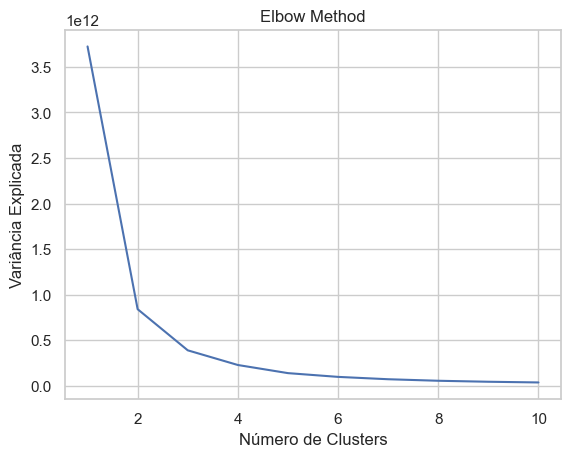

In [113]:
# Dataset sales1
X = sales1[['item', 'qtd']]

# Lista para armazenar as variâncias explicadas
variances = []

# Testar diferentes números de clusters
for n_clusters in range(1, 11):
    # Criar o modelo K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=1)
    kmeans.fit(X)
    
    # Obter a variância explicada pelo modelo
    variance = kmeans.inertia_
    variances.append(variance)

# Plotar o gráfico do método do cotovelo
plt.plot(range(1, 11), variances)
plt.xlabel('Número de Clusters')
plt.ylabel('Variância Explicada')
plt.title('Elbow Method')
plt.show()

Efetuando a análise no dataset sales1, colunas 'region' e 'qtd'. O objetivo dessa análise é identificar o ponto de "cotovelo" no gráfico, ou seja, o número de clusters onde a variância explicada começa a diminuir significativamente. Esse ponto geralmente indica um equilíbrio entre a complexidade do modelo (número de clusters) e a capacidade de explicar os dados.

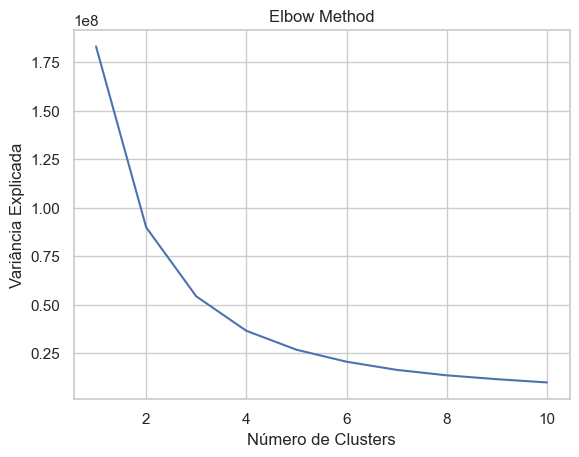

In [114]:
# Dataset sales1
X = sales1[['region', 'qtd']]

# Lista para armazenar as variâncias explicadas
variances = []

# Testar diferentes números de clusters
for n_clusters in range(1, 11):
    # Criar o modelo K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=1)
    kmeans.fit(X)
    
    # Obter a variância explicada pelo modelo
    variance = kmeans.inertia_
    variances.append(variance)

# Plotar o gráfico do método do cotovelo
plt.plot(range(1, 11), variances)
plt.xlabel('Número de Clusters')
plt.ylabel('Variância Explicada')
plt.title('Elbow Method')
plt.show()

Aplicando a redução de dimensionalidade no dataset para melhorar o desempenho

 Abaixo, as colunas numéricas são normalizadas usando StandardScaler e as colunas categóricas são codificadas usando pd.get_dummies. Em seguida, a redução de dimensionalidade é aplicada usando PCA com 2 componentes principais.

Tentando definir a melhor quantidade de clusters através do silhouette method.

Esses códigos aplicam o algoritmo K-means para diferentes números de clusters e calculam o índice de silhueta para cada caso. O índice de silhueta mede a coesão dos objetos dentro dos clusters e a separação entre os clusters. O número de clusters com o maior índice de silhueta é considerado o melhor número de clusters para a clusterização dos dados.






Primeiramente nas colunas 'item' e 'qtd'

*Foi interrompido devido ao tempo de execução ultrapassar os 25min.*

In [ ]:
'''# Separar as features
X = sales1[['item', 'qtd']]

# Lista para armazenar os valores do índice de silhueta
silhouette_scores = []

# Testar diferentes números de clusters
for n_clusters in range(2, 11):
    # Criar o modelo K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=1)
    kmeans.fit(X)
    
    # Obter as labels dos clusters
    labels = kmeans.labels_
    
    # Calcular o índice de silhueta
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

# Encontrar o número de clusters com maior índice de silhueta
best_n_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

# Imprimir o resultado
print("Melhor número de clusters:", best_n_clusters)

Nas colunas 'region' e 'qtd'

In [ ]:
'''# Separar as features
X = sales1[['region', 'qtd']]

# Lista para armazenar os valores do índice de silhueta
silhouette_scores = []

# Testar diferentes números de clusters
for n_clusters in range(2, 11):
    # Criar o modelo K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=1)
    kmeans.fit(X)
    
    # Obter as labels dos clusters
    labels = kmeans.labels_
    
    # Calcular o índice de silhueta
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

# Encontrar o número de clusters com maior índice de silhueta
best_n_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

# Imprimir o resultado
print("Melhor número de clusters:", best_n_clusters)

Abaixo, estamos efetuando o objeto PCA é instanciado com apenas 1 componente principal. O resultado é um novo dataframe com a coluna "pca_component_1" que representa a redução de dimensionalidade apenas das colunas "region" e "qtd".

In [ ]:
'''from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#selecionando apenas as colunas de interesse para reduzir o tamanho do dataset
sales_reduced = sales1.loc[:, ['region', 'qtd']]

# Selecionando apenas as colunas "region" e "qtd"
X = sales_reduced[['region', 'qtd']].values

# Instanciando o objeto PCA com 1 componente principal
pca = PCA(n_components=1)

# Aplicando o PCA aos dados
X_pca = pca.fit_transform(X)

# Criando um novo dataframe com a coluna reduzida
df_pca = pd.DataFrame(data=X_pca, columns=['pca_component_1'])

# Concatenando o novo dataframe com o dataframe original
result = pd.concat([sales_reduced, df_pca], axis=1)

# Imprimindo o novo dataframe com a coluna reduzida
print(result)

O código abaixo é uma tentativa de utilizar o "Silhouette Method" para encontrar a melhor quantidade de clusters.

Mas o consumo de memória RAM foi muito alto.

Aplicando no dataset sales1

In [ ]:
'''# Dados de entrada
X = sales_reduced[['region', 'qtd']]
# Parâmetros a serem pesquisados
param_grid = {'n_clusters': range(2, 10)}
# Criar o modelo de clusterização
kmeans = KMeans()
# Realizar a busca em grade
grid_search = GridSearchCV(kmeans, param_grid)
# Ajustar o GridSearch aos dados
grid_search.fit(X)
# Obter os melhores hiperparâmetros encontrados
best_params = grid_search.best_params_
best_n_clusters = best_params['n_clusters']
# Criar o modelo final com a melhor quantidade de clusters
best_model = KMeans(n_clusters=best_n_clusters)
best_model.fit(X)
# Predizer os clusters para os dados de entrada
labels = best_model.labels_
# Obter os centróides dos clusters
centroids = best_model.cluster_centers_
# Calcular as distâncias dos pontos aos centróides
distances = np.min(pairwise_distances_argmin_min(X, centroids), axis=1)

# Criar as colunas com valores nulos
sales_reduced['cluster'] = np.nan
sales_reduced['distance_to_centroid'] = np.nan

# Loop para atribuir os valores corretos às colunas
for i in range(len(sales_reduced)):
    cluster = labels[i]
    distance = distances[i]
    sales_reduced.loc[i, 'cluster'] = cluster
    sales_reduced.loc[i, 'distance_to_centroid'] = distance
    
# Adicionar as informações de cluster e distância ao dataframe original
sales_reduced['cluster'] = labels
sales_reduced['distance_to_centroid'] = distances
# Imprimir os resultados
print("Melhor quantidade de clusters:", best_n_clusters)
print("Centróides dos clusters:\n", centroids)
print("Distâncias dos pontos aos centróides:\n", distances)


Descobrindo a melhor quantidade de clusters atreavés do "Elbow Method"

O código abaixo usa-se a iteração sobre valores de k (número de clusters) de 1 a 9. Para cada valor de k, o modelo KMeans é ajustado aos dados e a soma dos quadrados das distâncias (sse) é calculada usando o atributo 'inertia_'. 

Em seguida, é plotado um gráfico mostrando a relação entre o número de clusters e a soma dos quadrados das distâncias. Com o objetivo de identificar o ponto de "Elbow" no gráfico, onde o ganho na redução da soma dos quadrados das distâncias começa a diminuir significativamente. Esse ponto pode ser considerado como a melhor quantidade de clusters para o conjunto de dados.

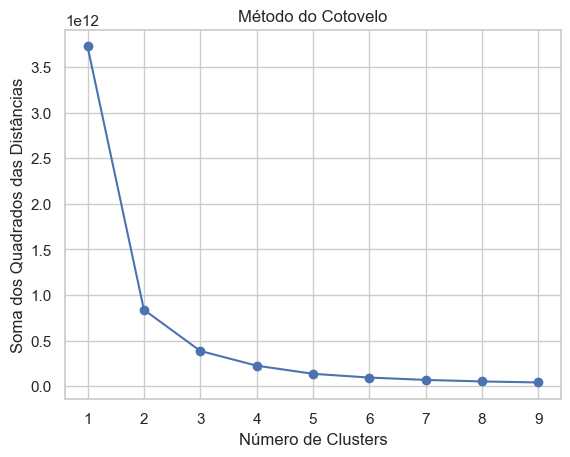

In [115]:
# Aplicando no dataset sales1

# Selecionar as colunas relevantes - item e quantidade
X = sales1[['item', 'qtd']]

# Lista para armazenar as somas dos quadrados das distâncias
sse = []

# Testar diferentes valores de número de clusters
for k in range(1, 10):
    # Instanciar o modelo KMeans
    kmeans = KMeans(n_clusters=k, random_state=0)  
    # Ajustar o modelo aos dados
    kmeans.fit(X)    
    # Obter a soma dos quadrados das distâncias
    sse.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo
plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Soma dos Quadrados das Distâncias')
plt.title('Método do Cotovelo')
plt.show()


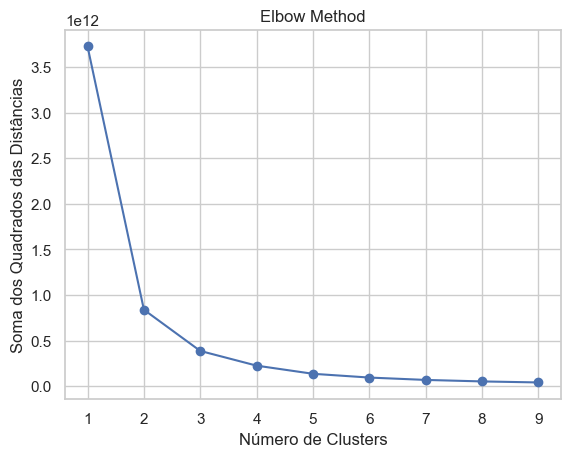

In [116]:
# Aplicando no dataset sales2

# Selecionar as colunas relevantes - item e quantidade
X = sales2[['item', 'qtd']]

# Lista para armazenar as somas dos quadrados das distâncias
sse = []

# Testar diferentes valores de número de clusters
for k in range(1, 10):
    # Instanciar o modelo KMeans
    kmeans = KMeans(n_clusters=k, random_state=0)
    # Ajustar o modelo aos dados
    kmeans.fit(X)
    # Obter a soma dos quadrados das distâncias
    sse.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo
plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Soma dos Quadrados das Distâncias')
plt.title('Elbow Method')
plt.show()

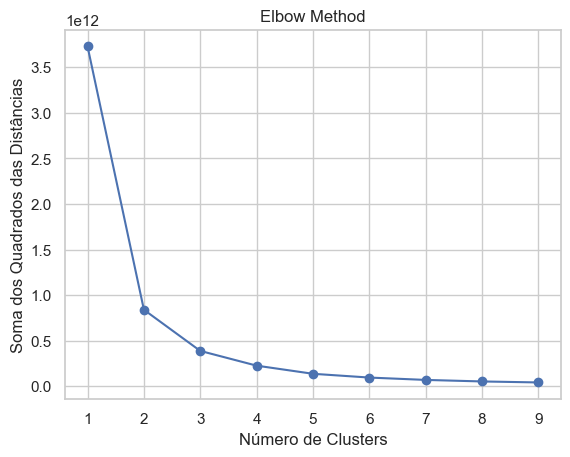

In [117]:
# Aplicando no dataset sales3

# Selecionar as colunas relevantes - item e quantidade
X = sales3[['item', 'qtd']]

# Lista para armazenar as somas dos quadrados das distâncias
sse = []

# Testar diferentes valores de número de clusters
for k in range(1, 10):
    # Instanciar o modelo KMeans
    kmeans = KMeans(n_clusters=k, random_state=0)
    
    # Ajustar o modelo aos dados
    kmeans.fit(X)
    
    # Obter a soma dos quadrados das distâncias
    sse.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo
plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Soma dos Quadrados das Distâncias')
plt.title('Elbow Method')
plt.show()

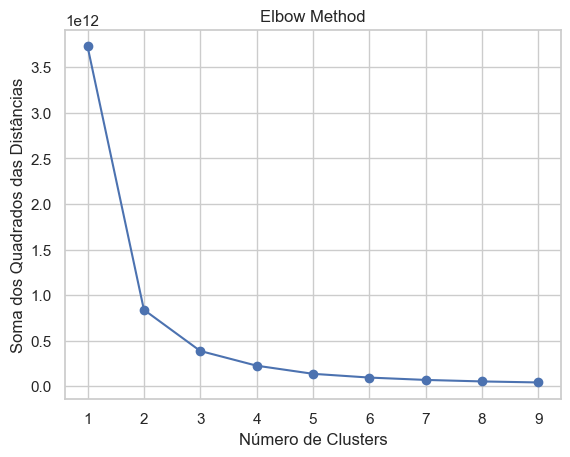

In [118]:
# Aplicando no dataset sales4

# Selecionar as colunas relevantes - item e quantidade
X = sales4[['item', 'qtd']]

# Lista para armazenar as somas dos quadrados das distâncias
sse = []

# Testar diferentes valores de número de clusters
for k in range(1, 10):
    # Instanciar o modelo KMeans
    kmeans = KMeans(n_clusters=k, random_state=0)
    
    # Ajustar o modelo aos dados
    kmeans.fit(X)
    
    # Obter a soma dos quadrados das distâncias
    sse.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo
plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Soma dos Quadrados das Distâncias')
plt.title('Elbow Method')
plt.show()

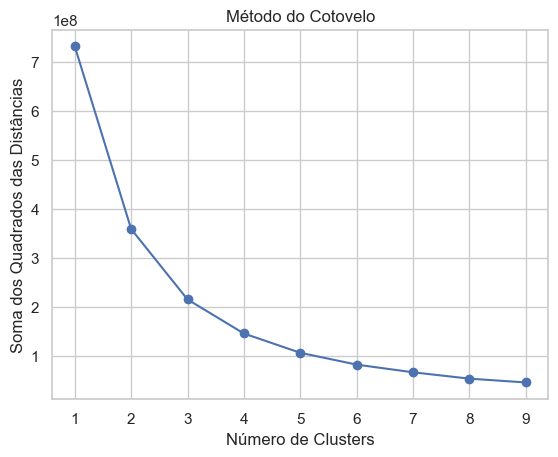

In [119]:
# Selecionar as colunas relevantes - item e região
X = sales[['region', 'qtd']]

# Lista para armazenar as somas dos quadrados das distâncias
sse = []

# Testar diferentes valores de número de clusters
for k in range(1, 10):
    # Instanciar o modelo KMeans
    kmeans = KMeans(n_clusters=k, random_state=0)
    
    # Ajustar o modelo aos dados
    kmeans.fit(X)
    
    # Obter a soma dos quadrados das distâncias
    sse.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo
plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Soma dos Quadrados das Distâncias')
plt.title('Método do Cotovelo')
plt.show()


Para isso, Utilizaremos o método kmodes.kprototypes para efetuar a clusterização dos dados categóricos e numéricos. 



In [ ]:
'''# selecionando as colunas de interesse
X = sales1[['item', 'qtd']]
# instanciando o objeto KPrototypes
kproto = KPrototypes(n_clusters=3, init='Cao')
# efetuando a clusterização
clusters = kproto.fit_predict(X.values, categorical=[0])
# adicionando as labes ao dataframe original
sales1['cluster'] = clusters

# plotando o gráfico
plt.scatter(sales1['item'], sales1['qtd'], c=sales1['cluster'])
plt.title('Clusterização de vendas')
plt.xlabel('Item')
plt.ylabel('Quantidade')
plt.show()

Nos códigos abaixo, foi utilizado o algoritmo K-means para realizar o clustering nos datasets sales1[['item', 'qtd']] e sales1[['region', 'qtd']]. Em seguida, é gerado um gráfico de dispersão onde cada ponto representa um exemplo do dataset, colorido de acordo com o cluster atribuído. Isso permite visualizar a distribuição dos dados e como eles foram agrupados pelo algoritmo de clustering.

*Efetuando* a clusterização entre as quantidades qtd e o item para ver se há algum comportamento semelhante.




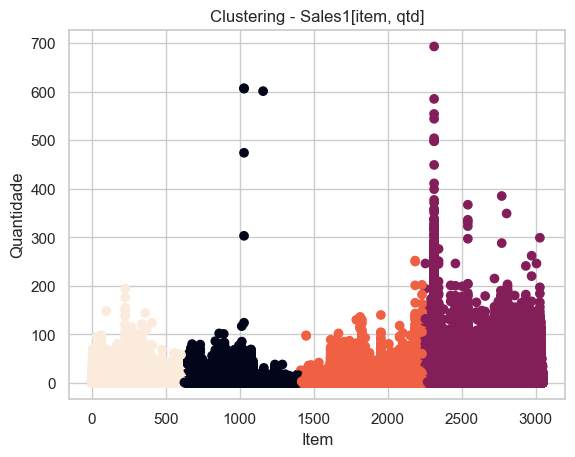

In [120]:
# Separar as features
X = sales1[['item', 'qtd']]

# Criar o modelo K-means
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(X)

# Obter as labels dos clusters
labels = kmeans.labels_

# Plotar o gráfico de dispersão
plt.scatter(X['item'], X['qtd'], c=labels)
plt.xlabel('Item')
plt.ylabel('Quantidade')
plt.title('Clustering - Sales1[item, qtd]')
plt.show()


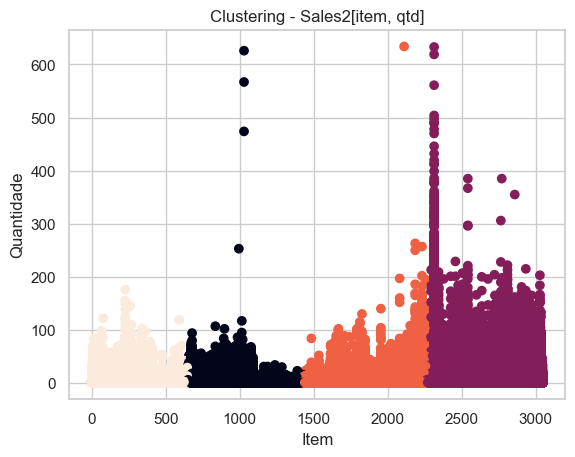

In [121]:
# Separar as features
X = sales2[['item', 'qtd']]

# Criar o modelo K-means
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(X)

# Obter as labels dos clusters
labels = kmeans.labels_

# Plotar o gráfico de dispersão
plt.scatter(X['item'], X['qtd'], c=labels)
plt.xlabel('Item')
plt.ylabel('Quantidade')
plt.title('Clustering - Sales2[item, qtd]')
plt.show()

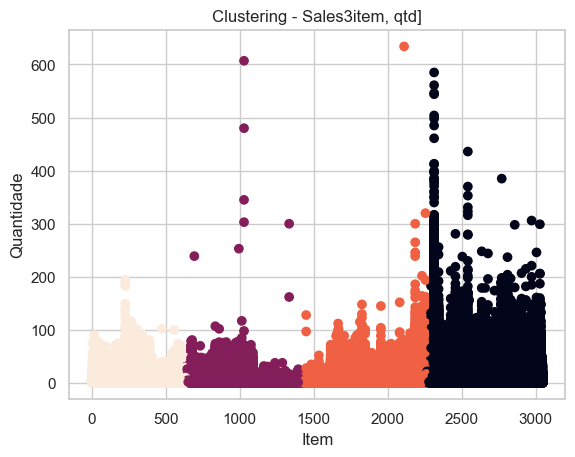

In [122]:
# Separar as features
X = sales3[['item', 'qtd']]

# Criar o modelo K-means
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(X)

# Obter as labels dos clusters
labels = kmeans.labels_

# Plotar o gráfico de dispersão
plt.scatter(X['item'], X['qtd'], c=labels)
plt.xlabel('Item')
plt.ylabel('Quantidade')
plt.title('Clustering - Sales3item, qtd]')
plt.show()

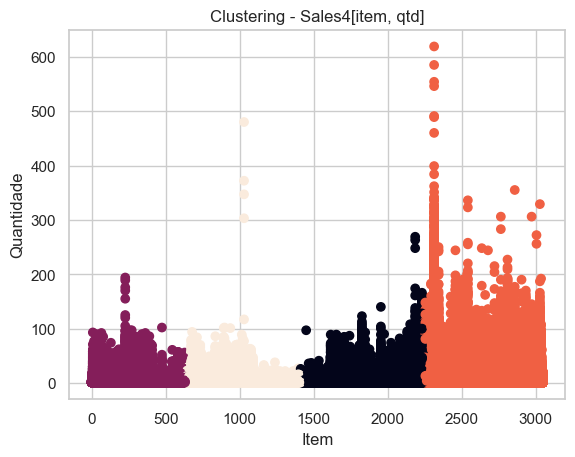

In [123]:
# Separar as features
X = sales4[['item', 'qtd']]

# Criar o modelo K-means
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(X)

# Obter as labels dos clusters
labels = kmeans.labels_

# Plotar o gráfico de dispersão
plt.scatter(X['item'], X['qtd'], c=labels)
plt.xlabel('Item')
plt.ylabel('Quantidade')
plt.title('Clustering - Sales4[item, qtd]')
plt.show()

*Efetuando* a clusterização entre as quantidades qtd e region para ver se há algum comportamento semelhante.


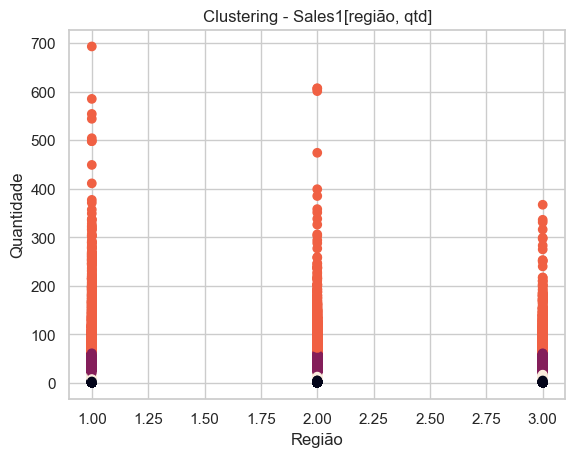

In [124]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Separar as features
X = sales1[['region', 'qtd']]

# Criar o modelo K-means
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(X)

# Obter as labels dos clusters
labels = kmeans.labels_

# Plotar o gráfico de dispersão
plt.scatter(X['region'], X['qtd'], c=labels)
plt.xlabel('Região')
plt.ylabel('Quantidade')
plt.title('Clustering - Sales1[região, qtd]')
plt.show()


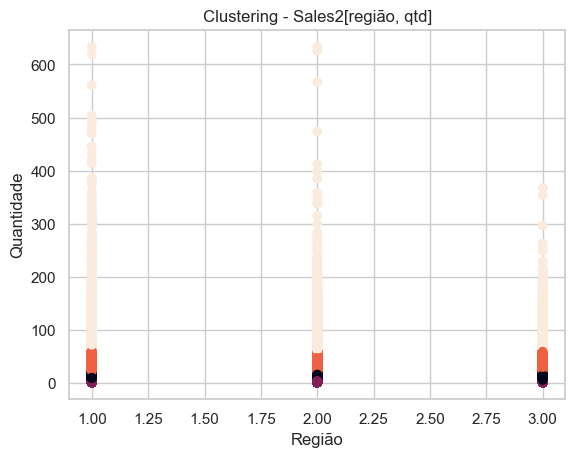

In [125]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Separar as features
X = sales2[['region', 'qtd']]

# Criar o modelo K-means
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(X)

# Obter as labels dos clusters
labels = kmeans.labels_

# Plotar o gráfico de dispersão
plt.scatter(X['region'], X['qtd'], c=labels)
plt.xlabel('Região')
plt.ylabel('Quantidade')
plt.title('Clustering - Sales2[região, qtd]')
plt.show()

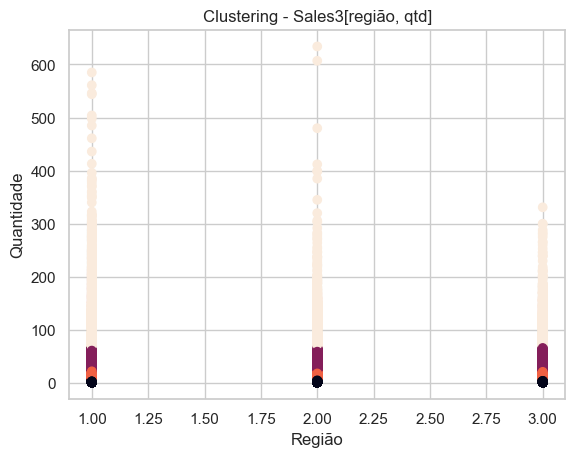

In [126]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Separar as features
X = sales3[['region', 'qtd']]

# Criar o modelo K-means
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(X)

# Obter as labels dos clusters
labels = kmeans.labels_

# Plotar o gráfico de dispersão
plt.scatter(X['region'], X['qtd'], c=labels)
plt.xlabel('Região')
plt.ylabel('Quantidade')
plt.title('Clustering - Sales3[região, qtd]')
plt.show()

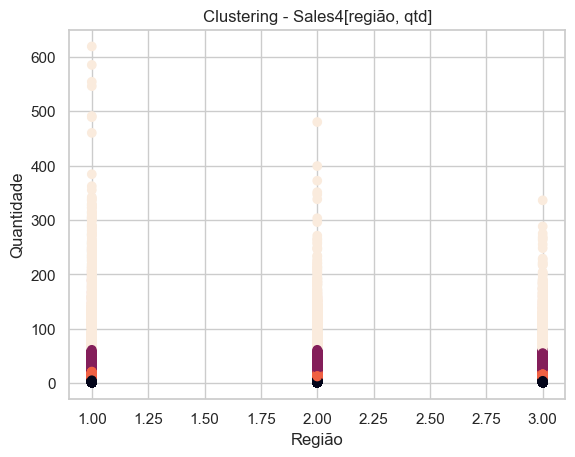

In [128]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Separar as features
X = sales4[['region', 'qtd']]

# Criar o modelo K-means
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(X)

# Obter as labels dos clusters
labels = kmeans.labels_

# Plotar o gráfico de dispersão
plt.scatter(X['region'], X['qtd'], c=labels)
plt.xlabel('Região')
plt.ylabel('Quantidade')
plt.title('Clustering - Sales4[região, qtd]')
plt.show()